<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihood_Hessians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [3]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     - 10.9MB 1.6MB/s


In [0]:
import corner

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0514 05:38:25.277037 140679712225152 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
generator_path   = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path     ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path    = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
plot_path        = './gdrive/My Drive/MPM/modules/gauss3b/plots/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final4/

assets	saved_model.pb	tfhub_module.pb  variables


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [56]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 64
hidden_size = 10
sigma_n     = 0.1
n_channels  = 1
data_dim    = 28*28

sample_size_z = 64
lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

def get_prior():
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')

prior = get_prior()

# ----------------------------------------------------------#


# uncorrupted data

prior_samples = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

encoded_data  = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma     = tf.split(encoded_data, 2, axis=-1)
sigma         = tf.nn.softplus(sigma) + 0.0001

approx_posterior_vae = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# -----------train NVP ----------------------#

# nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
# 

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = get_prior()
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])

# opt_op_nvp= optimizer.minimize(loss)

# -----------train NVP ----------------------#


#load NVP 
nvp_funcs     = hub.Module(nvp_func_path, trainable=False)


nvp_prior     = tf.placeholder_with_default(True,shape=[])

# ------------------- corrupted data -------------------#

# for corrupted data
batch_size2   = 1
sigma_corr    = tf.placeholder_with_default(np.ones([batch_size2,data_dim,n_channels], dtype='float32')*sigma_n,shape=[batch_size2,784,n_channels])
x_corr        = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

# encoded truth
x_ul          = tf.placeholder(shape=[batch_size2,data_dim,n_channels], dtype=tf.float32)

encoded_x     = encoder(tf.reshape(x_ul,[-1,28,28,n_channels]))
mu_x, sigma_x = tf.split(encoded_x, 2, axis=-1)



# ------- mean field VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size2,hidden_size)), dtype=np.float32)
sigma_elbo_    = tf.nn.softplus(sigma_elbo) + 0.0001

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo_, name='approxposterior_elbo')

kl_divergence     = tfd.kl_divergence(approx_posterior_elbo, prior) 
zz_               = approx_posterior_elbo.sample()
fwd_zz_           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_},as_dict=True)['fwd_pass'], lambda: zz_)
elbo_liklogits    = tf.reshape(generator(fwd_zz_),[-1,data_dim,n_channels])
corr_likelihood   = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits,scale_diag=sigma_corr))
elbo              = -tf.reduce_mean(corr_likelihood.log_prob(x_corr)- kl_divergence,axis=0)

opt_op_elbo       = optimizer.minimize(elbo,var_list=[mu_elbo,sigma_elbo])

mu_elbo_              = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_elbo},as_dict=True)['fwd_pass'], lambda: mu_elbo)
mu_liklogits          = tf.reshape(generator(mu_elbo_),[-1,data_dim,n_channels])
mean_corr_likelihood  = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_liklogits,scale_diag=sigma_corr)).mean()

samples_post_elbo     = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
samples_post_elbo     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':samples_post_elbo},as_dict=True)['fwd_pass'], lambda: samples_post_elbo)
sample_elbo_liklogits = tf.reshape(generator(tf.reshape(samples_post_elbo,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean      = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits,scale_diag=sigma_corr)).mean()

# ------- mean field VI on corrupted data ---------------#

# ------- full rank VI on corrupted data ---------------#
with tf.variable_scope("posterior_elbo_full_rank"):
  mu_f_elbo      = tf.Variable(np.zeros((batch_size2,hidden_size), dtype=np.float32), dtype=np.float32)
  sigma_f_elbo   = tf.Variable(np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32), dtype=tf.float32)

sigma_f_elbo_t = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_f_elbo), transform=tf.nn.softplus)

approx_posterior_f_elbo = tfd.MultivariateNormalTriL(loc=mu_f_elbo,scale_tril=sigma_f_elbo_t)


kl_divergence_f    = tfd.kl_divergence(approx_posterior_f_elbo, prior) 
zz_f               = approx_posterior_f_elbo.sample()
fwd_zz_f           = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':zz_f},as_dict=True)['fwd_pass'], lambda: zz_f)
elbo_liklogits_f   = tf.reshape(generator(fwd_zz_f),[-1,data_dim,n_channels])
corr_likelihood_f  = tfd.Independent(tfd.MultivariateNormalDiag(loc=elbo_liklogits_f,scale_diag=sigma_corr))
elbo_f             = -tf.reduce_mean(corr_likelihood_f.log_prob(x_corr)- kl_divergence_f,axis=0)

opt_op_elbo_f      = optimizer.minimize(elbo_f,var_list=[mu_f_elbo,sigma_f_elbo])

# likelihood of posterior mean
mu_elbo_f_             = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':mu_f_elbo},as_dict=True)['fwd_pass'], lambda: mu_f_elbo)
mu_f_liklogits         = tf.reshape(generator(mu_elbo_f_),[-1,data_dim,n_channels])
mean_corr_likelihood_f = tfd.Independent(tfd.MultivariateNormalDiag(loc=mu_f_liklogits,scale_diag=sigma_corr)).mean()
sample_post_elbo_f     = tf.reshape(approx_posterior_f_elbo.sample(sample_size_z),[-1,hidden_size])
sample_post_elbo_f     = tf.cond(nvp_prior, lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':sample_post_elbo_f},as_dict=True)['fwd_pass'], lambda: sample_post_elbo_f)
sample_elbo_liklogits_f= tf.reshape(generator(tf.reshape(sample_post_elbo_f,[batch_size2*sample_size_z,hidden_size])),[batch_size2, sample_size_z, data_dim, n_channels])
sample_elbo_mean_f     = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_elbo_liklogits_f,scale_diag=sigma_corr)).mean()

# ------- full rank VI on corrupted data ---------------#



#### for naive recon and strating MAP finding at truth


### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size2,hidden_size]),shape=[batch_size2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size2,data_dim,n_channels])

likeli_MAP           = tfd.Independent(tfd.MultivariateNormalDiag(loc=genMAP,scale_diag=sigma_corr))

likeli_log_prob      = likeli_MAP.log_prob(x_corr)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_log_prob

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op_MAP           = optimizer.minimize(loss_MAP, var_list=[MAP])



##### ----------  do Laplace approximation ----------- #####
true_hess  = tf.placeholder_with_default(True,shape=[])
diag_hess  = tf.placeholder_with_default(False,shape=[])


ini_val  = np.ones((batch_size2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float64)
with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size2,hidden_size),dtype=np.float32), dtype=np.float64)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus),dtype=tf.float64)
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)



# this is exact hessian computation 
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

# constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)

grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.cond(true_hess, lambda: tf.linalg.eigvalsh(hess2), lambda: tf.linalg.eigvalsh(hess_approx))

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(tf.cast(hess2,tf.float64)), lambda: tf.linalg.inv(tf.cast(hess_approx,tf.float64)))

scale            = tf.placeholder_with_default(1.,shape=[])

#allow for cooling
sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))*tf.cast(scale, tf.float64)

# try taking only the diagonal
sigma_diag       = tf.expand_dims(tf.linalg.tensor_diag(tf.linalg.diag_part(sigma_hess[0])),0)

eig2             = tf.linalg.eigvalsh(sigma_hess)

sigma_hess_      = tf.cond(diag_hess, lambda: tf.linalg.cholesky(sigma_diag), lambda: tf.linalg.cholesky(sigma_hess))

MAP_             = tf.cast(MAP, tf.float64)
update2          = mu_new.assign(MAP_)
update3          = sigma_new_t2.assign(sigma_hess_)

log_det          = tf.linalg.logdet(approx_posterior_laplace.covariance())

# evaluation
lap_z_samples     = tf.cast(tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size]),dtype=tf.float32)
fwd_zs            = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':lap_z_samples},as_dict=True)['fwd_pass'], lambda:lap_z_samples) 
lap_liklogits     = tf.reshape(generator(fwd_zs),[-1,784,n_channels])
lap_likelihood    = tfd.Independent(tfd.MultivariateNormalDiag(loc=lap_liklogits,scale_diag=sigma_corr))
lap_mean          = lap_likelihood.mean()
lapl_variance_MAP = tf.linalg.diag_part(approx_posterior_laplace.covariance())

# minimize elbo with mu fixed at MAP, make sure nvp prior is set correctly
update4           = mu_elbo.assign(MAP_ini)
opt_op_elbo2      = optimizer.minimize(elbo,var_list=[sigma_elbo])


# minimize elbo_f with mu fixed at MAP, make sure nvp prior is set correctly
update5           = mu_f_elbo.assign(MAP_ini)
opt_op_elbo2f     = optimizer.minimize(elbo_f,var_list=[sigma_f_elbo])

num_chains =20

def unnormalized_log_prob(x):
  
  fwd_x              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':x},as_dict=True)['fwd_pass']

  # option to use uncorrected latent space
  gen_x              = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_x), lambda: generator(x)),[num_chains,data_dim,n_channels])

  likeli_x           = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_x,scale_diag=sigma_corr))

  likeli_log_prob_x  = likeli_x.log_prob(x_corr)

  prior_x            = prior.log_prob(x)

  posterior_x        = prior_x+likeli_log_prob_x

  return posterior_x


#### ----- this is an hmc sampler------------#

# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=np.ones((num_chains,hidden_size),dtype=np.float32)*1.,
    use_resource=True,  # For TFE compatibility.
    trainable=False)



ini_chain = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)
# Initialize the HMC transition kernel.
num_results = int(2e4)
num_burnin_steps = int(2e3)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_log_prob,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

# Run the chain (with burn-in).
hmc_samples, hmc_kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_steps_between_results=10,
    num_burnin_steps=num_burnin_steps,
    current_state=ini_chain,
    kernel=hmc)
#### ----- this is an hmc sampler------------#

#### ----- this is a a Random Walk Metropolis Hastings------------#

# Initial state of the chain
init_state = tf.cast(np.asarray(np.ones((hidden_size,num_chains),dtype=np.float32)*np.linspace(0,1,num_chains)).T, tf.float32)

# Run Random Walk Metropolis with normal proposal for `num_results`
# iterations for `num_chains` independent chains:
mcmc_samples, mcmc_stats = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_log_prob,
        seed=54,
        new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=0.1,name=None)),
    num_burnin_steps=num_burnin_steps,
    num_steps_between_results=10,  # Thinning.
    parallel_iterations=1)


# # # construct a GMM approximation from different minima
num_comp = 4
with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((batch_size2,num_comp,hidden_size)), dtype=np.float32)
  ini_val2    = np.ones((batch_size2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
  sigma_gmm   = tf.constant(ini_val2)
  sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

mu_est        = tf.placeholder_with_default(tf.zeros([batch_size2,num_comp,hidden_size]),shape=[batch_size2,num_comp,hidden_size])
sigma_est     = tf.placeholder_with_default(tf.ones([batch_size2,num_comp,hidden_size, hidden_size]),shape=[batch_size2,num_comp,hidden_size, hidden_size])
w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_a      = w_gmm.assign(w_est)
update_b      = mu_gmm.assign(mu_est)
update_c      = sigma_gmmt.assign(sigma_est)

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

gmm_sample_z  = tf.squeeze(gmm.sample(sample_size_z))
gmm_fwd       = tf.cond(nvp_prior,lambda: nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':gmm_sample_z},as_dict=True)['fwd_pass'], lambda:gmm_sample_z)
gmm_fwd       = tf.reshape(generator(gmm_fwd),[-1,data_dim,1])
gmm_sample_x  =tfd.Independent(tfd.MultivariateNormalDiag(loc=gmm_fwd,scale_diag=sigma_corr)).mean()

# saver         = tf.train.Saver()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:33.177122 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:33.238320 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:33.327193 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:33.988725 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:34.443228 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:34.535025 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:36.979872 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:37.084877 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:37.547854 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:37.664299 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:38.187531 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:38.326461 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:39.618872 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:39.765848 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:40.292642 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:40.456165 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:40.818534 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:40.976467 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:41.086813 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:45.135462 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:45.313633 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:47.029595 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:47.238751 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:47.389825 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:49.648833 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:49.924226 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:50.111752 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:52.663051 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:52.938876 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:53.161477 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:53.928057 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:54.213942 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:54.440443 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:55.387416 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 06:12:55.663385 140679712225152 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Reconstruct uncorrupted test data and inspect samples**

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

(64, 784, 1)
(64, 784, 1)


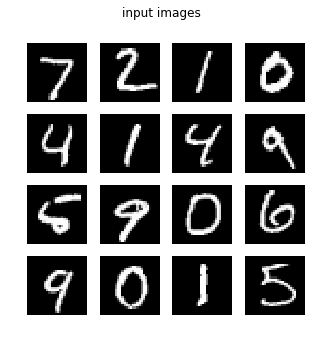

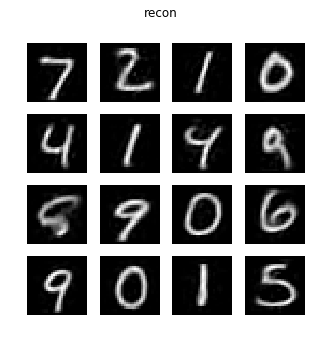

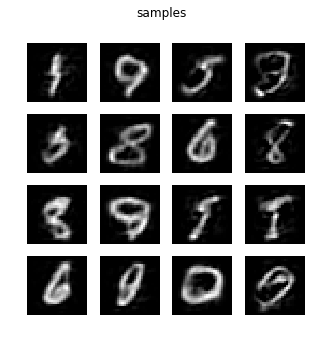

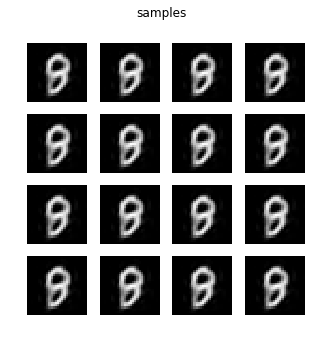

In [12]:
p_samples = sess.run(prior_sample)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('recon')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(rec[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
p_samples = np.zeros_like(p_samples)
rec, samples = sess.run([recon,sample_mean], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_samples: p_samples})

print(samples.shape)
figure(figsize=(5,5))
suptitle('samples')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(samples[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

**Fit NVP to posterior for better samples**

In [0]:
# nvp_loss = []
# ii     = 0
# nepoch = 0
# learning_rate = 1e-3

In [0]:
# #train the nvp
# while nepoch<1000:
#   if (ii+1)*batch_size>len(x_train): 
#     np.random.shuffle(x_train)
#     ii=0
#     nepoch+=1
#     print('starting epoch', nepoch)
#   if nepoch>10:
#     learning_rate=1e-5
#   if nepoch>200:
#     learning_rate=1e-6
#   x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
#   _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
#   nvp_loss+=[ll]
#   if ii%500==0:
#     print(ll)
#   ii+=1

In [0]:
# plt.figure()
# plot(nvp_loss[::],label='nvp loss')
# legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 00:01:25.966770 140526495975296 saver.py:1483] Saver not created because there are no variables in the graph to restore


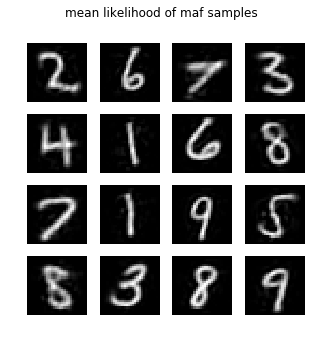

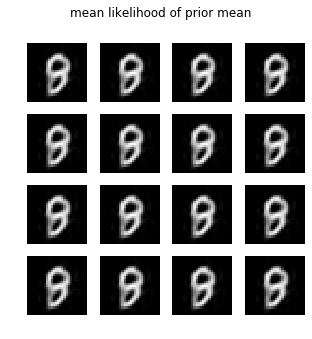

In [147]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_samples: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
s = sess.run(sample_mean, feed_dict={prior_samples: np.zeros_like(samples1)})

figure(figsize=(5,5))
suptitle('mean likelihood of prior mean')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [13]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior_vae.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0514 04:53:53.923635 139941427271552 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


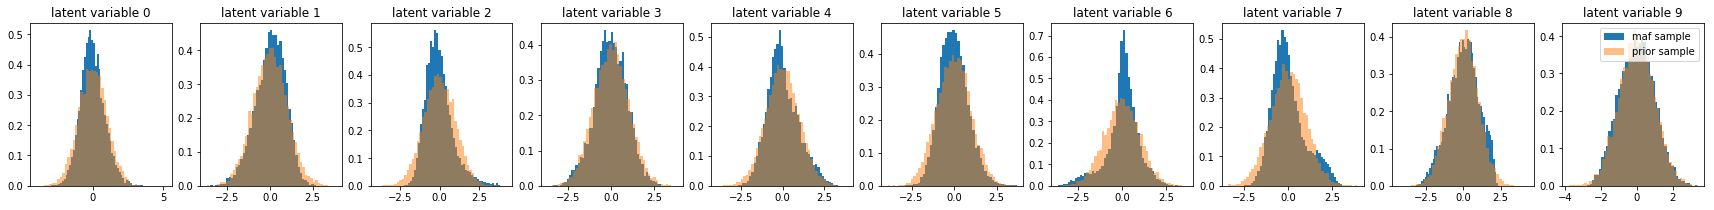

In [14]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

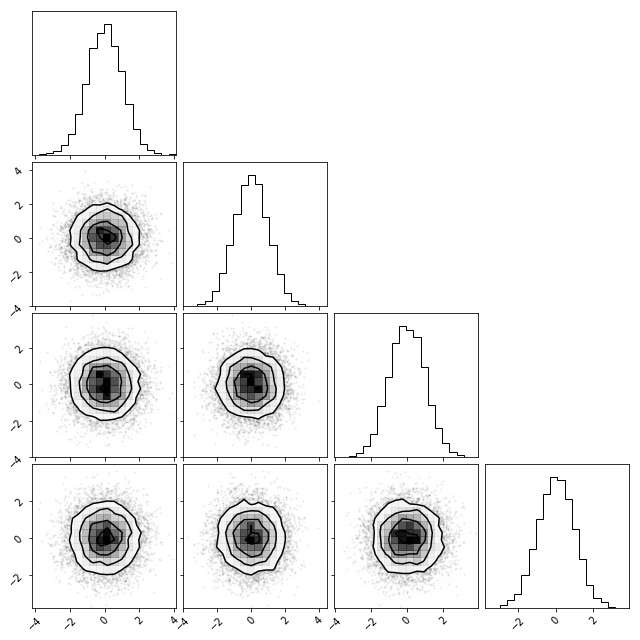

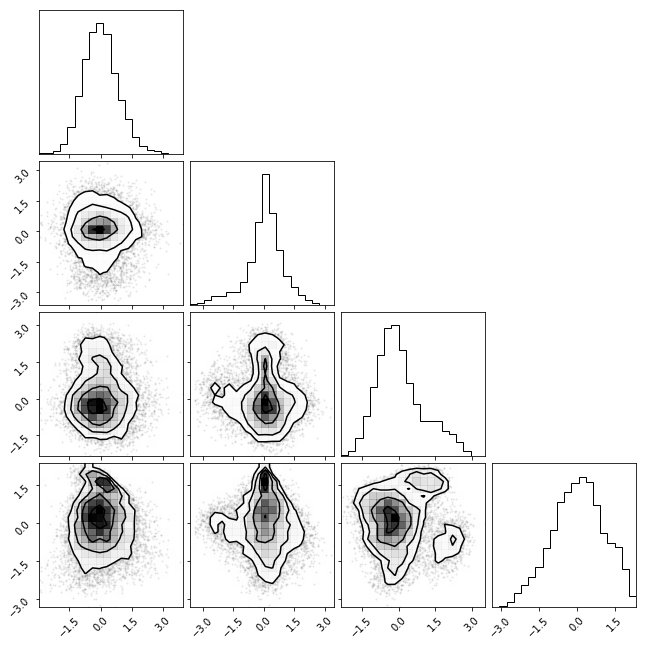

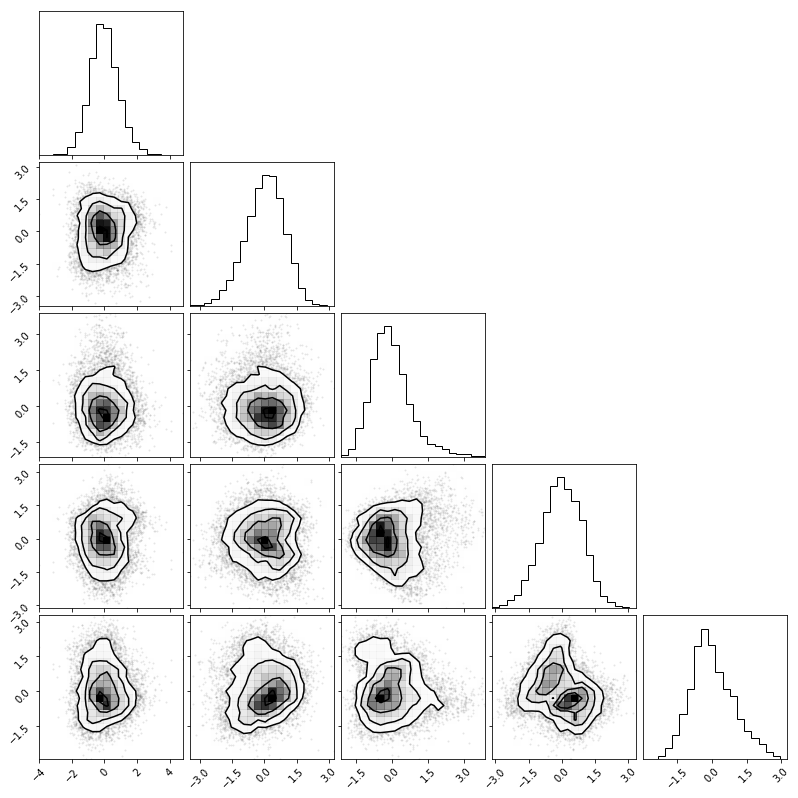

In [150]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])
_ = corner.corner(maf_s[:,0:5])

**Make corrupted data**

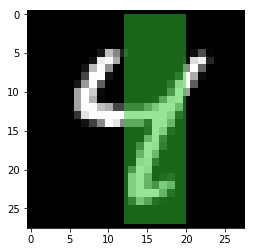

In [58]:

mask = np.ones(IMAGE_SHAPE, dtype=int)
# use also 12:18/12:20 -> 4 
minx = 12
maxx = 20
mask[0:28,minx:maxx]=0.
mask = mask.reshape((28*28))
sigma_new = np.ones(mask.shape)*sigma_n
sigma_new[np.where(mask==0)] = sigma_n*1e4
x_true = x_test[6:6+batch_size2]
masked_data = x_true*[mask]
sigma_new = np.asarray([np.expand_dims(sigma_new,-1)]*batch_size2)

data = np.expand_dims(masked_data,-1)
plt.figure()
_=plt.imshow(x_true.reshape((28,28)),cmap='gray',vmin=0)
x = np.arange(28)
plt.fill_between(x, 0, 27, where=[(x>=minx)*(x<=maxx)][0] ,facecolor='limegreen', alpha=0.5)
plt.show()


**Minimize ELBO for corrupted data and look at samples**

A) mean field

In [0]:
posterior_loss=[]

In [16]:
lrate=1e-3
for ii in range(8000):
  if ii >4000:
    lrate=1e-4
  _, ll = sess.run([opt_op_elbo, elbo],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

1564.7582
1564.7448
1574.2214
1559.3718
1565.1539
1564.2334
1564.629
1562.3933
1560.683
1562.1718
1567.8799
1562.048
1562.7922
1567.685
1565.1062
1570.4708
1570.172
1564.7614
1561.9016
1577.1627
1565.4417
1573.759
1560.4006
1561.2622
1569.9203
1562.7479
1562.6553
1565.0996
1570.6991
1566.0269
1566.6405
1566.2235
1565.014
1563.5637
1562.6548
1561.0768
1560.2025
1563.0988
1562.735
1564.5205
1562.7155
1560.8954
1560.3079
1570.1409
1563.0653
1577.7041
1567.4054
1563.5527
1562.8153
1561.5978
1562.7965
1563.1375
1560.0608
1566.3066
1566.5803
1567.1786
1561.7579
1568.679
1567.6724
1560.3936
1569.122
1567.263
1564.2046
1559.8845
1560.1151
1564.4182
1566.1938
1565.1519
1564.8352
1561.9601
1567.9937
1562.2471
1560.165
1565.4103
1563.8184
1570.2865
1566.9536
1563.8947
1566.987
1562.6936


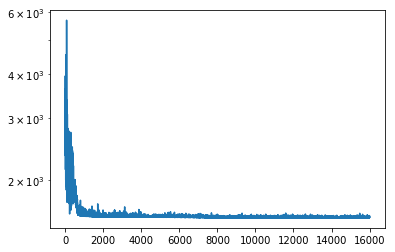

In [17]:
plt.plot(posterior_loss)
yscale('log')

In [18]:
mean    = sess.run(mean_corr_likelihood,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

VI_mean, VI_cov = sess.run([approx_posterior_elbo.mean(),approx_posterior_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss     = sess.run(approx_posterior_elbo.log_prob(VI_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_min_loss = - VI_min_loss
print(VI_mean,VI_min_loss)

[[ 3.2704213   4.5155826  -3.1326864  -2.9258034   1.0401441   0.35453212
   0.4123463  -0.28714365  0.8699621   0.7430447 ]] [-21.835232]


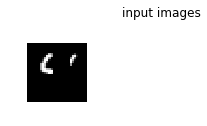

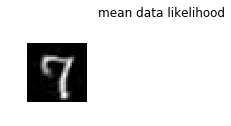

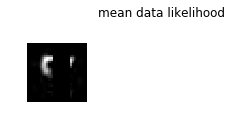

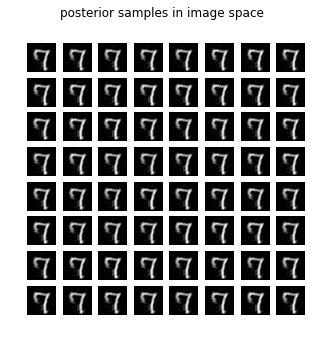

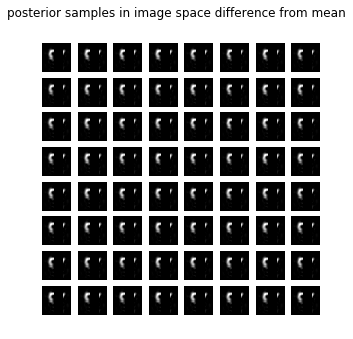

In [47]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'mfVImasked_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:

import pickle
try:
  VI_mean, VI_cov, VI_loss = pickle.load(open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([VI_mean, VI_cov, VI_min_loss],open(minima_path+'nvp_meanfieldVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))


B) full rank

In [0]:
posterior_loss=[]
#sess.run([reset_elbo, reset_elbo2],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})

In [31]:
lrate=1e-5
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo_f, elbo_f],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
  posterior_loss.append(ll)
  if ii%100==0:
    print(ll)

1551.1636
1548.5251
1551.56
1549.564
1553.5713
1548.3108
1550.5482
1550.0325
1552.4857
1547.0195
1549.0939
1550.7131
1552.8971
1549.0525
1551.2181
1546.1265
1551.836
1547.1296
1550.8413
1554.253


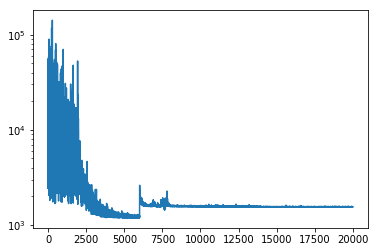

In [32]:
plt.plot(posterior_loss)
yscale('log')

In [33]:
mean   = sess.run(mean_corr_likelihood_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
samples = sess.run(sample_elbo_mean_f,feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_mean, VI_f_cov = sess.run([approx_posterior_f_elbo.mean(),approx_posterior_f_elbo.covariance()],feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = sess.run(approx_posterior_f_elbo.log_prob(VI_f_mean),feed_dict={x_corr: np.expand_dims(masked_data,-1), lr:lrate, sigma_corr:sigma_new, nvp_prior:True})
VI_f_min_loss = -VI_f_min_loss
print(VI_f_mean,VI_f_min_loss)

[[ 3.5079944   0.7371363  -1.4297009  -0.13092583  1.5087953   1.0178286
  -0.6335821  -1.0474669   1.6948527   0.7556737 ]] [-17.391068]


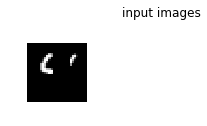

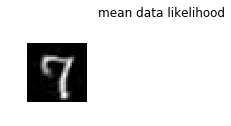

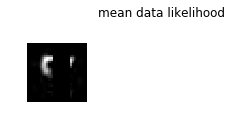

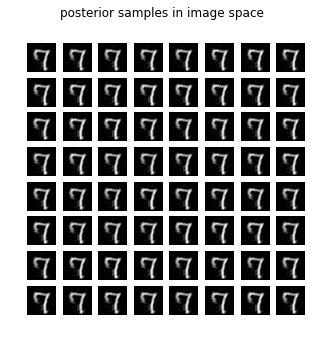

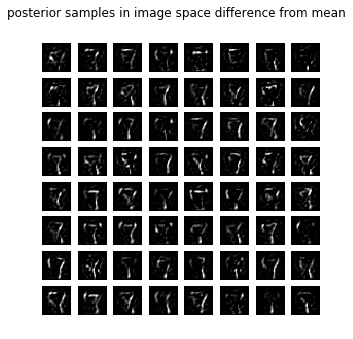

In [48]:
# try different starting values for VI?

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(mean[i,:,0]*mask,(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.show()


figure(figsize=(5,5))
suptitle('posterior samples in image space')
for i in range(min(batch_size2,16)):
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')

plt.show()
figure(figsize=(5,5))
suptitle('posterior samples in image space difference from mean')
for i in range(min(batch_size2,16)):
    mean_sample = np.mean(samples[i,:,:,0],axis=0)
    for j in range(64):
      subplot(8,8,j+1)
      imshow(np.reshape(samples[i,j,:,0]-mean_sample,(28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
plt.savefig(plot_path+'frfVI_samplesmasked_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

In [0]:
try:
  VI_f_mean, VI_f_cov,VI_f_min_loss = pickle.load(open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([VI_f_mean, VI_f_cov,VI_f_min_loss],open(minima_path+'nvp_fullrankVI_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))

**find minima with nvp**

0
2318.1853
1207.452
1200.3251
1200.6693
1204.2903
1203.0374
1212.344
1201.2615
1200.5604
1202.7968
switching to lr 0.01
1199.8059
1198.4376
1198.3806
1198.5205
1198.4177
switching to lr 0.001
1198.8553
1198.3646
1
1943.1671
1341.179
1340.5956
1340.6432
1340.6014
1341.0231
1341.5258
1230.6407
1204.362
1199.7734
switching to lr 0.01
1199.4813
1198.4116
1198.4109
1198.4692
1198.4556
switching to lr 0.001
1198.413
1198.3518
2
3158.8994
1949.9357
1948.7549
1949.024
1949.2698
1949.6543
1949.2483
1950.7529
1952.9889
1203.6083
switching to lr 0.01
1206.039
1201.1847
1200.3203
1200.1228
1199.9556
switching to lr 0.001
1199.9192
1199.8115
3
2414.7686
1554.4161
1554.7317
1549.9418
1550.6858
1542.2299
1567.0586
1541.5101
1542.551
1542.0526
switching to lr 0.01
1542.1871
1541.6785
1541.6498
1541.651
1541.6498
switching to lr 0.001
1541.697
1541.615
4
3354.928
2058.3137
2060.827
2061.926
2061.5146
2063.9746
2064.9714
2062.2512
2058.457
2054.2559
switching to lr 0.01
2064.1438
2050.5244
2050.69
2050

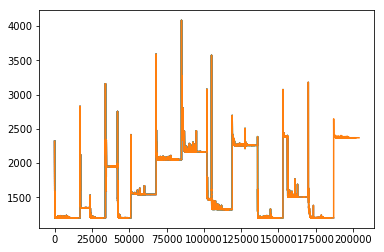

In [39]:
posterior_corr_loss=[]

l_minima=[]
map_minima=[]
for ii in range(12):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))+1e-8
  elif ii==0:
    #starting from truth
    ini = sess.run(mu_x,feed_dict={x_ul: np.expand_dims(x_true,-1)})
  else:
    ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(10000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, lr: lrate})
    posterior_corr_loss.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_corr_loss,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new})]

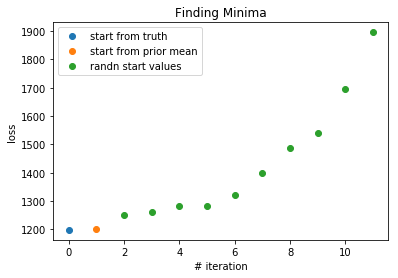

In [53]:
plt.figure()
plt.title('Finding Minima')
plt.plot(0,l_minima[0],ls='',marker='o',label='start from truth')
plt.plot(1,l_minima[1],ls='',marker='o',label='start from prior mean')
plt.plot(np.arange(len(l_minima)-2)+2,l_minima[2::],ls='',marker='o', label='randn start values')
plt.xlabel('# iteration')
plt.ylabel('loss')
plt.legend()
plt.savefig(plot_path+'minimzation_results_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')

plt.show()

In [0]:
import pickle
try:
  l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima,map_minima],open(minima_path+'nvp_minima_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))
  
map_minima = np.asarray(map_minima)
l_minima   = np.asarray(l_minima)

In [42]:
print(map_minima[0])
print(VI_f_mean)
print(VI_mean)

[[[ 2.6803303   0.52356946 -1.3828627   0.76382756  0.7004655
    0.9963898  -0.18421985 -3.4723957   1.1985819  -0.34135965]]]
[[ 3.5079944   0.7371363  -1.4297009  -0.13092583  1.5087953   1.0178286
  -0.6335821  -1.0474669   1.6948527   0.7556737 ]]
[[ 3.2704213   4.5155826  -3.1326864  -2.9258034   1.0401441   0.35453212
   0.4123463  -0.28714365  0.8699621   0.7430447 ]]


**Sample posterior of (un)corrupted data**

In [0]:
samples_mcmc, mcmc_stats_ = sess.run([mcmc_samples,mcmc_stats],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

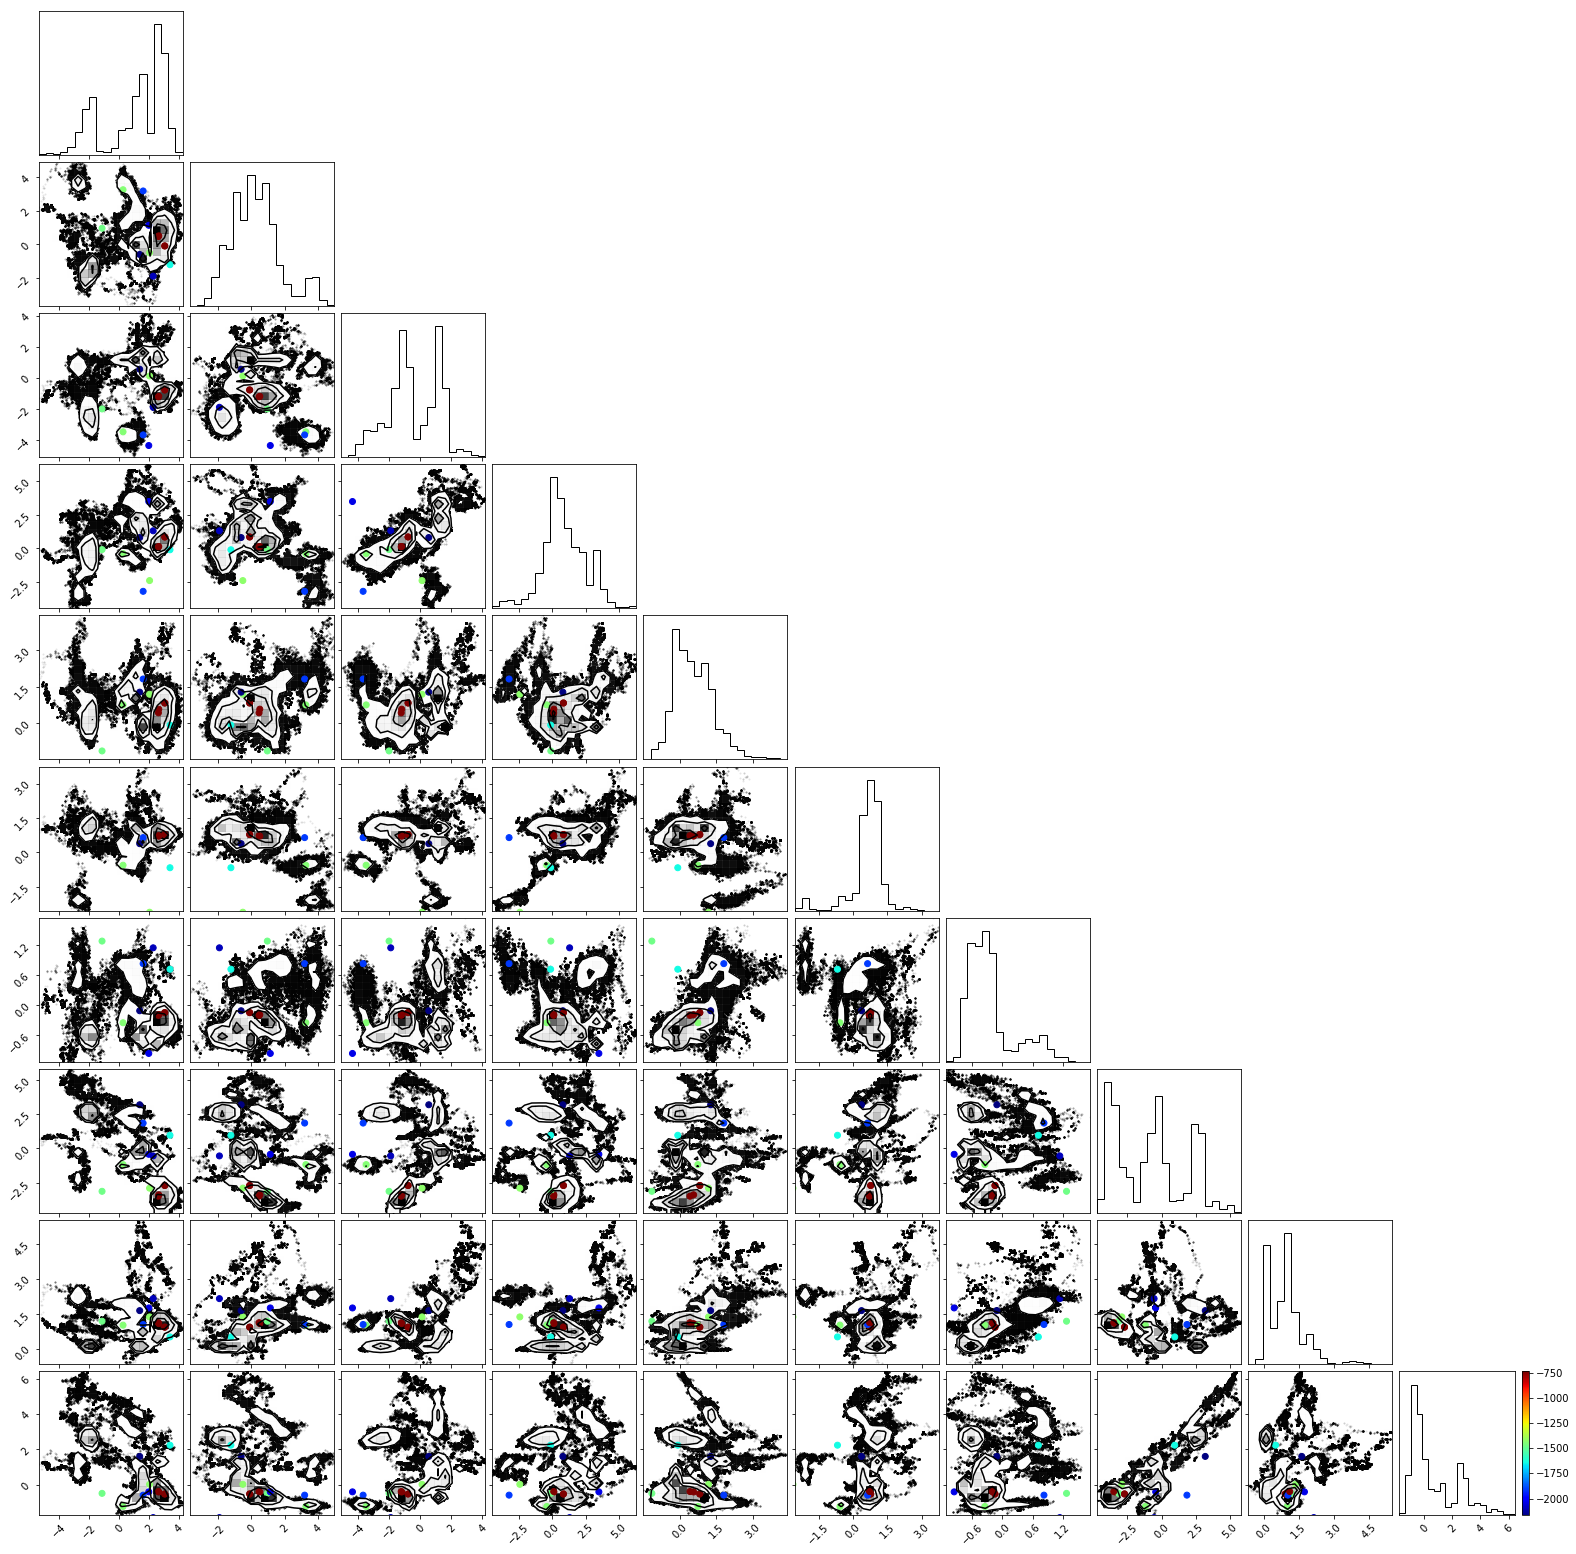

In [123]:
figure = corner.corner(np.reshape(samples_mcmc,[-1,hidden_size]))
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

In [0]:
#corrupted data
samples_, kernel_results_ = sess.run([hmc_samples, hmc_kernel_results],feed_dict={x_corr: np.expand_dims(masked_data,-1),sigma_corr:sigma_new, nvp_prior:True})

In [96]:
samples_.shape
print(max(kernel_results_.accepted_results.target_log_prob.flatten()),-min(l_minima))

-987.4353 -734.68427


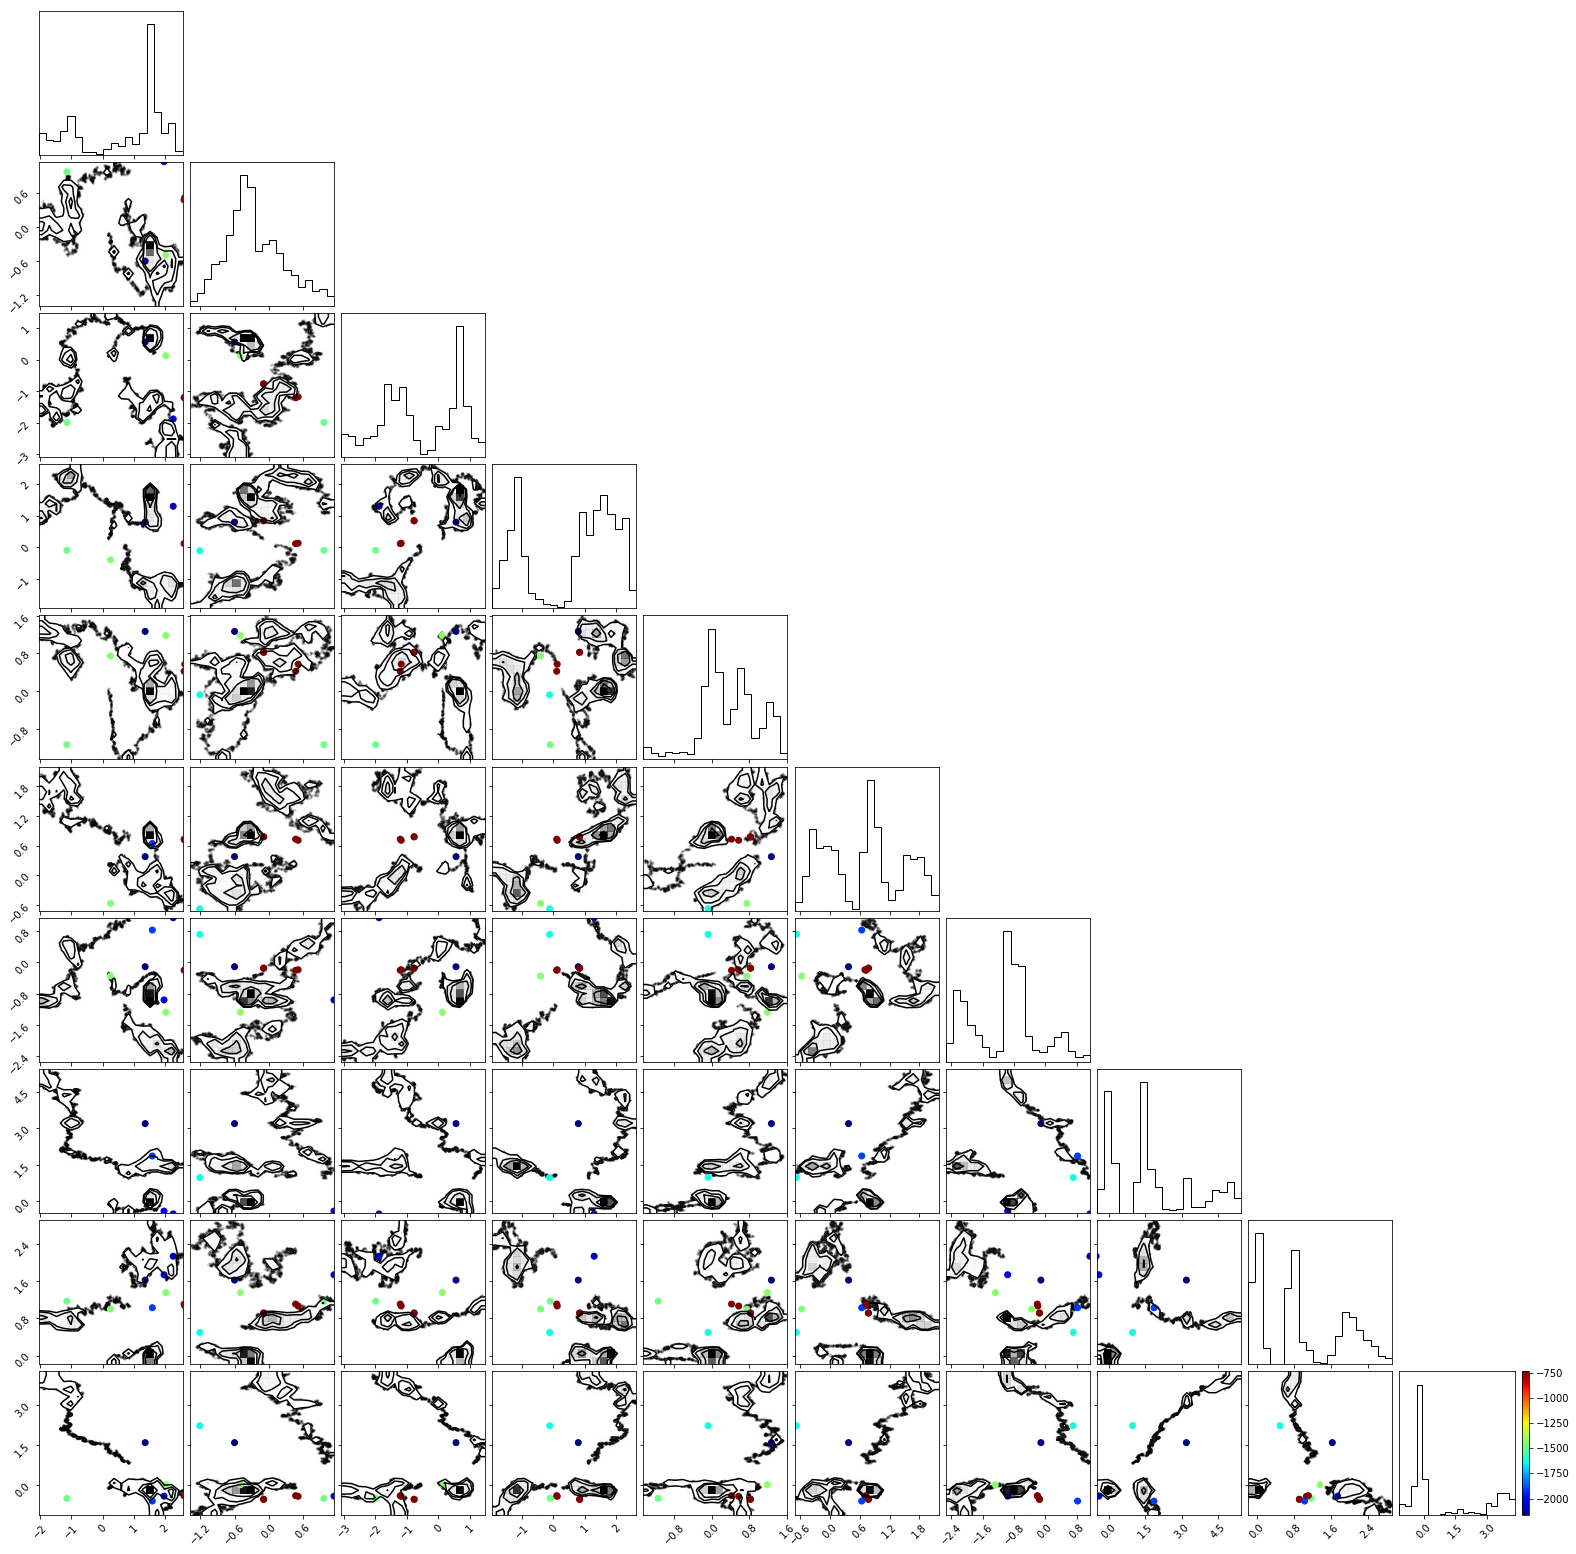

In [111]:
order = np.argsort(l_minima)

figure = corner.corner(np.reshape(samples_,[-1,hidden_size]))#,truths = map_minima_old[order][0,0,0,:])
axes   = np.array(figure.axes).reshape((hidden_size, hidden_size))

# # # # Loop over the histograms
for yi in range(hidden_size):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax_=ax.scatter(map_minima[:,0,0,xi], map_minima[:,0,0,yi], c=-l_minima, cmap='jet')
        #for i, txt in enumerate(l_minima_old):
        #  ax.annotate('%d'%txt, (map_minima_old[i,0,0,xi], map_minima_old[i,0,0,yi]),color='red', fontsize=10)
plt.colorbar(ax_)

mean:0.1693  stddev:0.9419  acceptance:0.6615


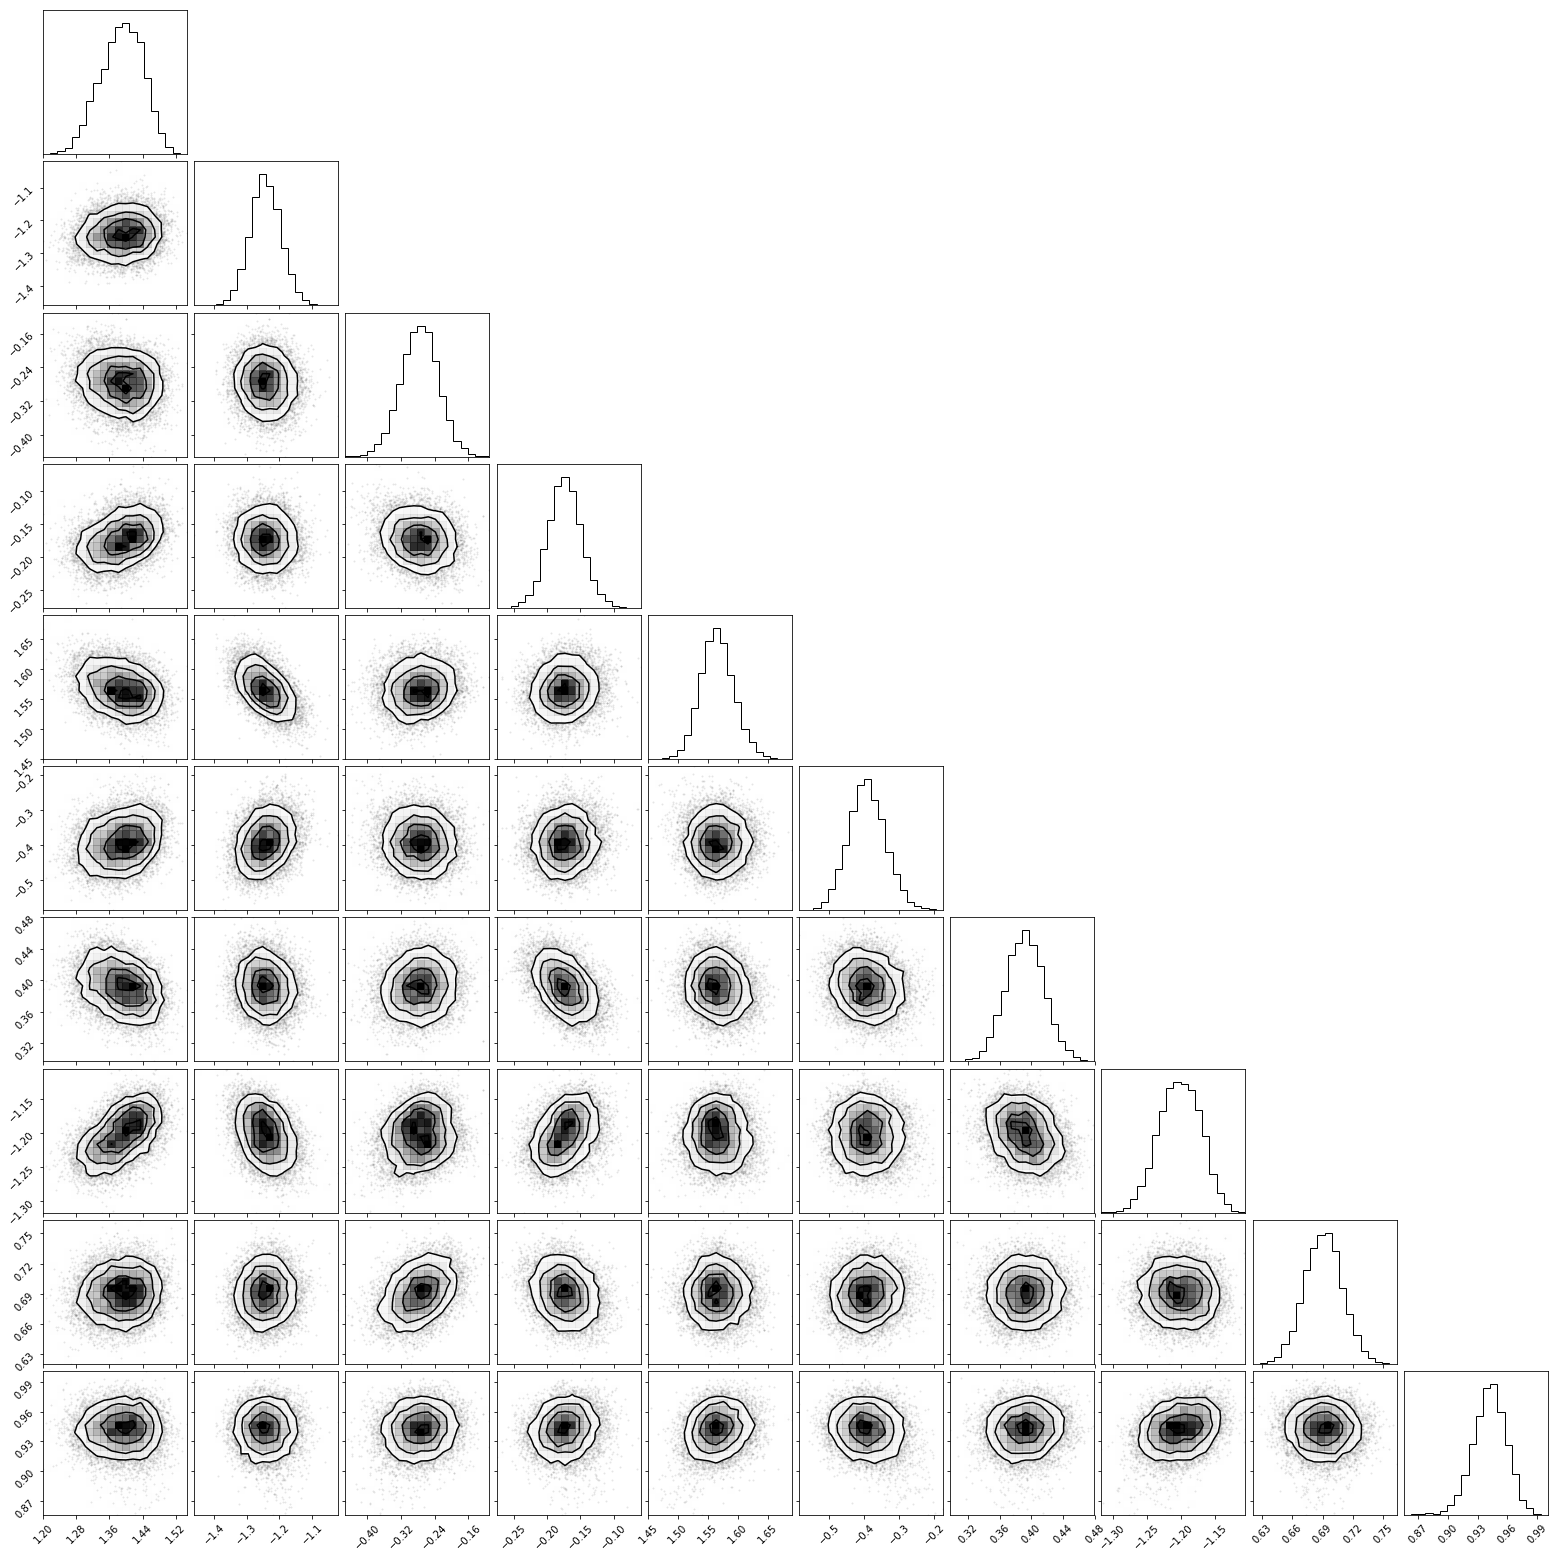

In [16]:
#uncorrupted data
samples_, kernel_results_ = sess.run([samples, kernel_results],feed_dict={x_corr: np.expand_dims(x_true,-1)})
_ = corner.corner(samples_[:,0,:])

**get covariances around minima**

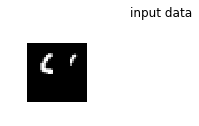

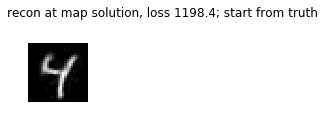

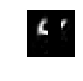

eigenvalues before and after inverse, approx hessian
[array([[9.7585571e-01, 9.9931765e-01, 9.9982888e-01, 9.9997526e-01,
        1.0000039e+00, 1.0003829e+00, 1.0006591e+00, 1.0026572e+00,
        1.0032164e+00, 3.2838872e+05]], dtype=float32), array([[3.04517203e-06, 9.96912660e-01, 9.98871241e-01, 9.99453753e-01,
        9.99856428e-01, 9.99961386e-01, 1.00000086e+00, 1.00018302e+00,
        1.00046454e+00, 1.00324110e+00]])]


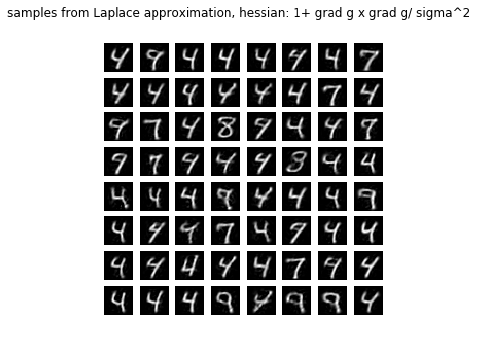

covariances
(1, 10, 10)


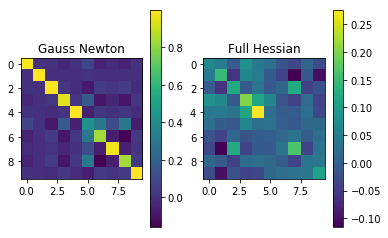

hessians
(1, 10, 10)


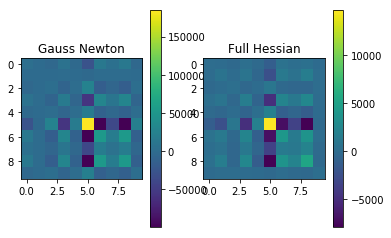

eigenvalues before and after inverse, full hessian
[array([[2.0876303e+00, 3.0203218e+00, 5.3519268e+00, 7.3468990e+00,
        3.3290947e+01, 1.5977466e+02, 3.9714737e+02, 9.6773419e+02,
        1.4250183e+03, 2.5745162e+04]], dtype=float32), array([[3.88422478e-05, 7.01745704e-04, 1.03334213e-03, 2.51796185e-03,
        6.25885453e-03, 3.00381687e-02, 1.36115484e-01, 1.86846869e-01,
        3.31119570e-01, 4.79071016e-01]])]
1


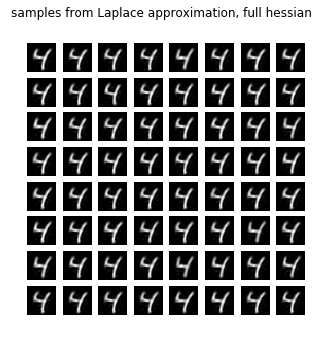

diagonal approx


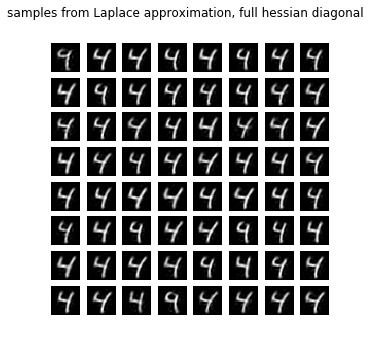

hessian successful 0


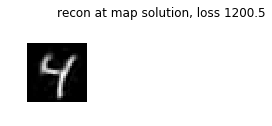

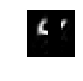

eigenvalues before and after inverse, approx hessian
[array([[9.9826729e-01, 9.9969250e-01, 9.9995834e-01, 9.9999970e-01,
        1.0000105e+00, 1.0000378e+00, 1.0001545e+00, 1.0005311e+00,
        1.0031785e+00, 2.2764780e+05]], dtype=float32), array([[4.39275112e-06, 9.96883824e-01, 9.99676182e-01, 9.99936202e-01,
        9.99985508e-01, 9.99999972e-01, 1.00000465e+00, 1.00003364e+00,
        1.00017905e+00, 1.00226759e+00]])]


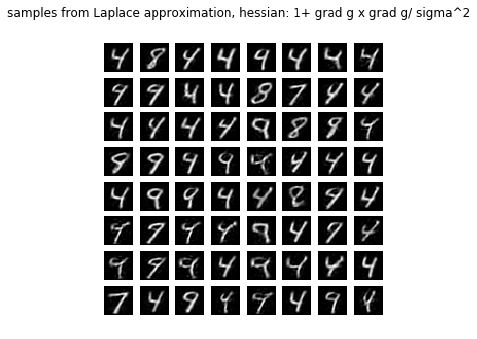

covariances
(1, 10, 10)


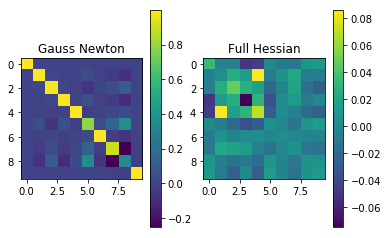

hessians
(1, 10, 10)


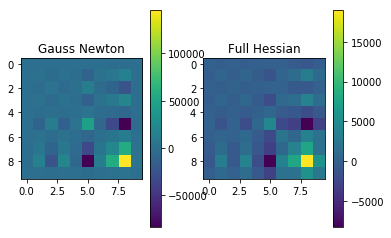

eigenvalues before and after inverse, full hessian
[array([[-1.4085288e+01, -9.3331146e+00,  5.2732115e+00,  1.6697481e+01,
         2.7528893e+01,  1.8196382e+02,  3.2465503e+02,  6.1820270e+02,
         2.8352432e+03,  3.0192385e+04]], dtype=float32), array([[-1.07144410e-01, -7.09983439e-02,  3.31209316e-05,
         3.52703454e-04,  1.61759354e-03,  3.08018057e-03,
         5.49555730e-03,  3.63253446e-02,  5.98879689e-02,
         1.89628628e-01]])]
1
full hessian fails


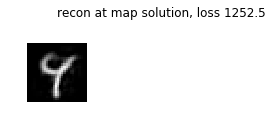

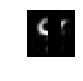

eigenvalues before and after inverse, approx hessian
[array([[9.8981214e-01, 9.9826264e-01, 9.9896151e-01, 9.9993181e-01,
        1.0003365e+00, 1.0006814e+00, 1.0012972e+00, 1.0047886e+00,
        1.0331326e+00, 7.2960538e+05]], dtype=float32), array([[1.37060404e-06, 9.93795223e-01, 9.97786940e-01, 9.98240288e-01,
        9.99576224e-01, 1.00000512e+00, 1.00019593e+00, 1.00114948e+00,
        1.00169534e+00, 1.00524152e+00]])]


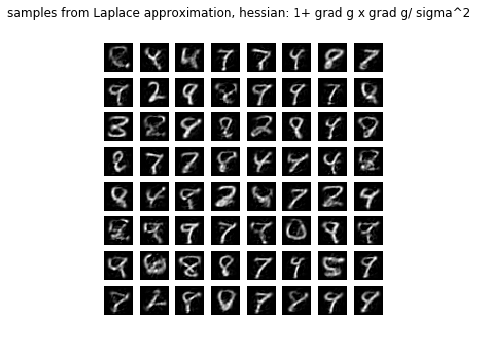

covariances
(1, 10, 10)


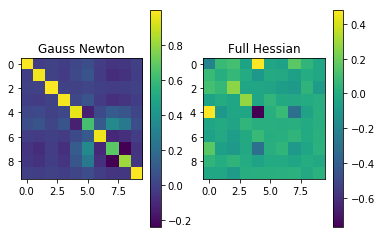

hessians
(1, 10, 10)


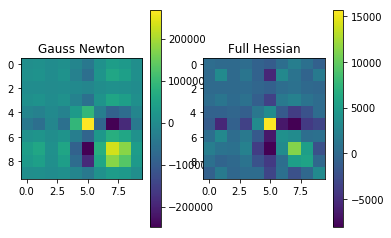

eigenvalues before and after inverse, full hessian
[array([[-8.3533937e-01,  2.4750259e+00,  3.5570195e+00,  2.2565342e+01,
         1.7476898e+02,  3.0841565e+02,  7.5837836e+02,  4.1802354e+03,
         1.0727436e+04,  2.9622754e+04]], dtype=float32), array([[-1.19685160e+00,  3.37578409e-05,  9.32189273e-05,
         2.39221054e-04,  1.31860129e-03,  3.24238464e-03,
         5.72183502e-03,  4.43157052e-02,  2.81138203e-01,
         4.04013596e-01]])]
1
full hessian fails


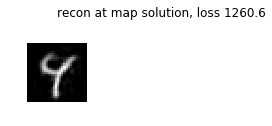

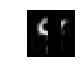

eigenvalues before and after inverse, approx hessian
[array([[9.9591321e-01, 9.9951559e-01, 9.9971819e-01, 9.9996150e-01,
        9.9999994e-01, 9.9999994e-01, 1.0000806e+00, 1.0008869e+00,
        1.0086398e+00, 1.3933981e+05]], dtype=float32), array([[7.17670094e-06, 9.97913271e-01, 9.99415818e-01, 9.99958626e-01,
        9.99999888e-01, 1.00000006e+00, 1.00006665e+00, 1.00010982e+00,
        1.00044894e+00, 1.00183932e+00]])]


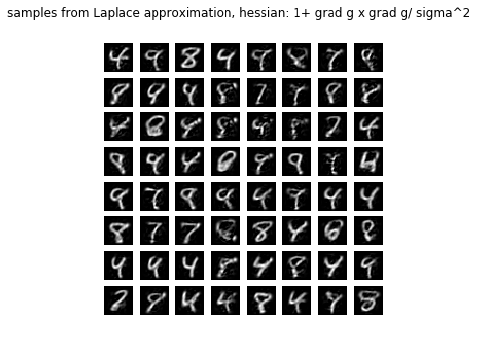

covariances
(1, 10, 10)


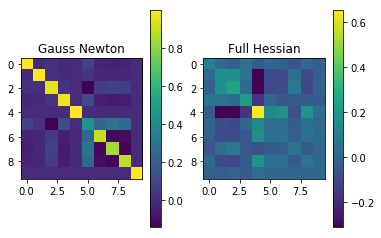

hessians
(1, 10, 10)


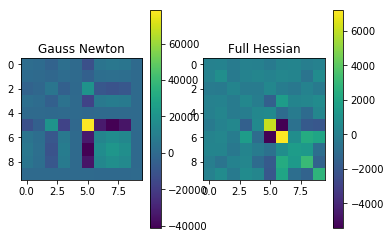

eigenvalues before and after inverse, full hessian
[array([[8.6074024e-01, 3.4880948e+00, 9.5733109e+00, 1.6843296e+01,
        4.2617092e+01, 1.8920905e+02, 1.4642842e+03, 1.7446987e+03,
        5.3538682e+03, 1.4126868e+04]], dtype=float32), array([[7.07870911e-05, 1.86780772e-04, 5.73164685e-04, 6.82927099e-04,
        5.28515184e-03, 2.34644212e-02, 5.93707033e-02, 1.04456778e-01,
        2.86689263e-01, 1.16143994e+00]])]
1


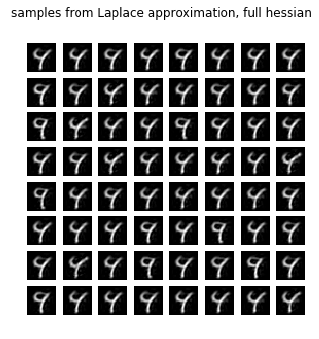

diagonal approx


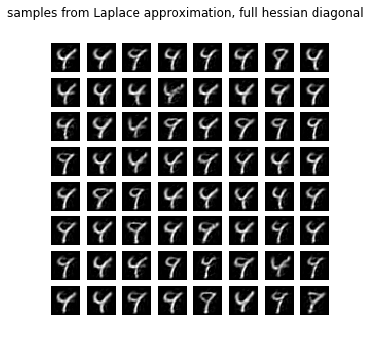

hessian successful 3


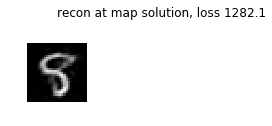

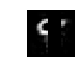

eigenvalues before and after inverse, approx hessian
[array([[9.9738181e-01, 9.9961293e-01, 9.9980170e-01, 9.9997962e-01,
        9.9999350e-01, 1.0000110e+00, 1.0001417e+00, 1.0005312e+00,
        1.0114598e+00, 4.0200659e+05]], dtype=float32), array([[2.48752163e-06, 9.97037276e-01, 9.99735301e-01, 9.99880937e-01,
        9.99974379e-01, 1.00000436e+00, 1.00003465e+00, 1.00004940e+00,
        1.00037993e+00, 1.00373658e+00]])]


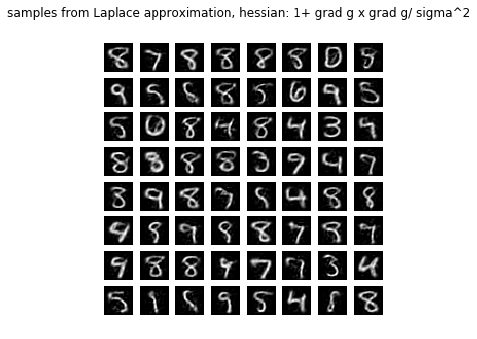

covariances
(1, 10, 10)


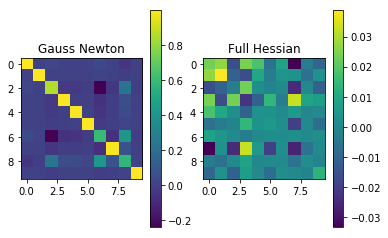

hessians
(1, 10, 10)


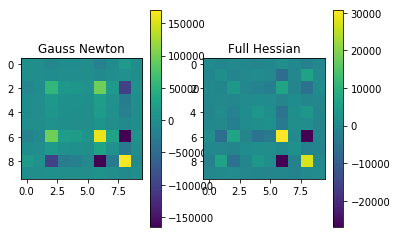

eigenvalues before and after inverse, full hessian
[array([[-9.6427126e+00,  1.3669435e+01,  2.5219826e+01,  5.9551033e+01,
         1.3546579e+02,  5.1775208e+02,  1.6633424e+03,  2.8066008e+03,
         7.6696172e+03,  6.0101766e+04]], dtype=float32), array([[-1.03708060e-01,  1.66384446e-05,  1.30384558e-04,
         3.56303022e-04,  6.01199393e-04,  1.93142720e-03,
         7.38195063e-03,  1.67923136e-02,  3.96505130e-02,
         7.31579506e-02]])]
1
full hessian fails


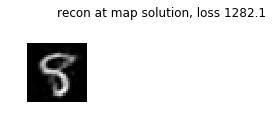

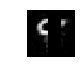

eigenvalues before and after inverse, approx hessian
[array([[9.9782628e-01, 9.9964470e-01, 9.9977058e-01, 9.9996465e-01,
        1.0000260e+00, 1.0000829e+00, 1.0001996e+00, 1.0006655e+00,
        1.0095296e+00, 1.6061633e+05]], dtype=float32), array([[6.22601657e-06, 9.98966176e-01, 9.99243948e-01, 9.99937456e-01,
        9.99968773e-01, 1.00001029e+00, 1.00010762e+00, 1.00015531e+00,
        1.00057308e+00, 1.00223052e+00]])]


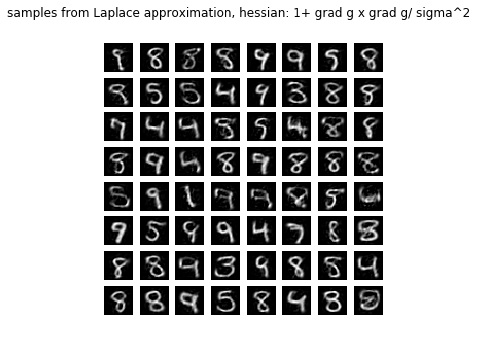

covariances
(1, 10, 10)


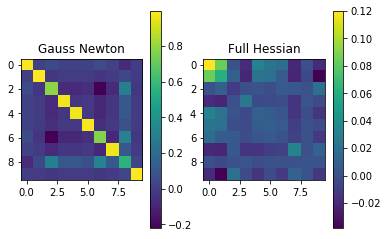

hessians
(1, 10, 10)


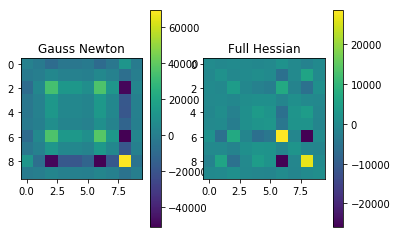

eigenvalues before and after inverse, full hessian
[array([[-1.9930946e+01,  4.6825886e+00,  2.1175423e+01,  5.4772995e+01,
         1.5138866e+02,  4.4901709e+02,  1.1850778e+03,  2.7481221e+03,
         9.4369258e+03,  5.8250344e+04]], dtype=float32), array([[-5.01709646e-02,  1.71672816e-05,  1.05966673e-04,
         3.63884887e-04,  8.43825025e-04,  2.22708509e-03,
         6.60554051e-03,  1.82571102e-02,  4.72243574e-02,
         2.13565308e-01]])]
1
full hessian fails


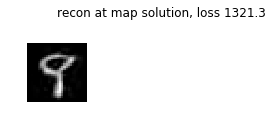

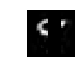

eigenvalues before and after inverse, approx hessian
[array([[9.9527615e-01, 9.9948436e-01, 9.9990022e-01, 9.9996328e-01,
        1.0000011e+00, 1.0000185e+00, 1.0002463e+00, 1.0012127e+00,
        1.0068887e+00, 6.2668734e+04]], dtype=float32), array([[1.59569203e-05, 9.99008103e-01, 9.99309230e-01, 9.99851421e-01,
        9.99949270e-01, 9.99982380e-01, 1.00000119e+00, 1.00003030e+00,
        1.00020480e+00, 1.00090853e+00]])]


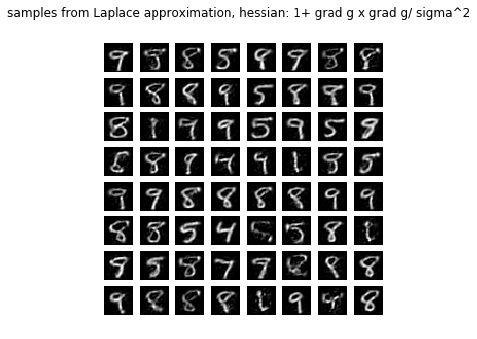

covariances
(1, 10, 10)


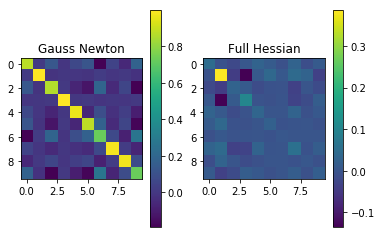

hessians
(1, 10, 10)


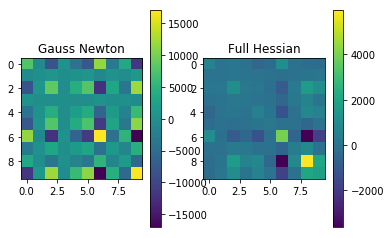

eigenvalues before and after inverse, full hessian
[array([[2.1591268e+00, 7.7078176e+00, 1.7051134e+01, 2.7273806e+01,
        5.1098667e+01, 1.6407651e+02, 4.6892993e+02, 1.3660903e+03,
        2.2027800e+03, 1.0584375e+04]], dtype=float32), array([[9.44788859e-05, 4.53971748e-04, 7.32016344e-04, 2.13251435e-03,
        6.09472011e-03, 1.95699620e-02, 3.66653714e-02, 5.86475710e-02,
        1.29739217e-01, 4.63146349e-01]])]
1


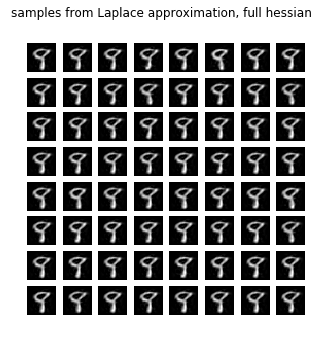

diagonal approx


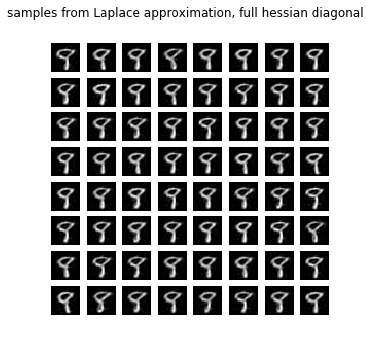

hessian successful 6


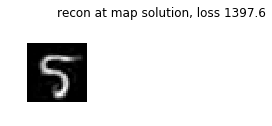

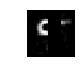

eigenvalues before and after inverse, approx hessian
[array([[9.9603868e-01, 9.9825871e-01, 9.9960864e-01, 9.9992561e-01,
        9.9999636e-01, 1.0000145e+00, 1.0003048e+00, 1.0004497e+00,
        1.0012828e+00, 1.2791321e+05]], dtype=float32), array([[7.81780133e-06, 9.98714926e-01, 9.99886617e-01, 9.99901540e-01,
        9.99995677e-01, 1.00000125e+00, 1.00005148e+00, 1.00044593e+00,
        1.00105195e+00, 1.00254167e+00]])]


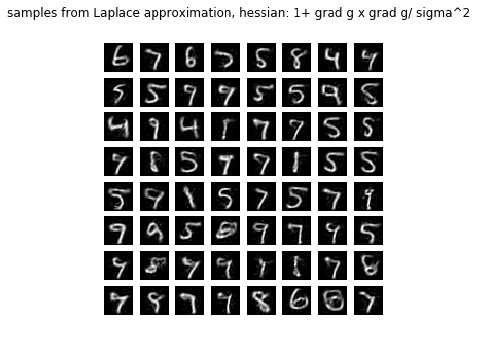

covariances
(1, 10, 10)


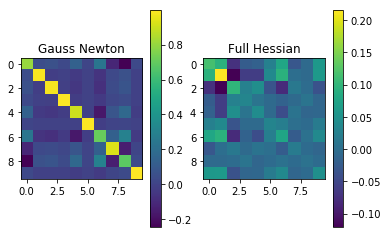

hessians
(1, 10, 10)


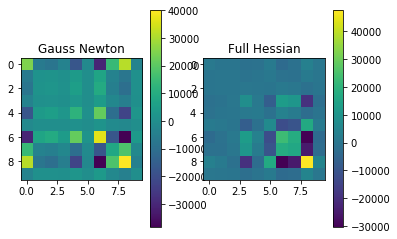

eigenvalues before and after inverse, full hessian
[array([[2.0856540e+00, 1.1149031e+01, 1.7066065e+01, 3.2937538e+01,
        5.1572502e+01, 2.3073535e+02, 4.0140060e+02, 2.6695737e+03,
        4.1746279e+03, 9.8311844e+04]], dtype=float32), array([[1.01717154e-05, 2.39542279e-04, 3.74591396e-04, 2.49126854e-03,
        4.33397210e-03, 1.93899090e-02, 3.03600374e-02, 5.85976005e-02,
        8.96970722e-02, 4.79305704e-01]])]
1


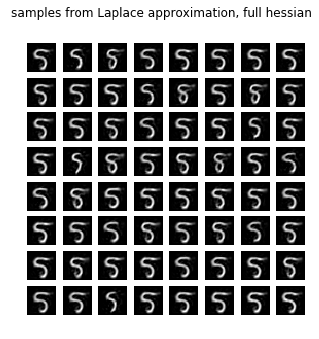

diagonal approx


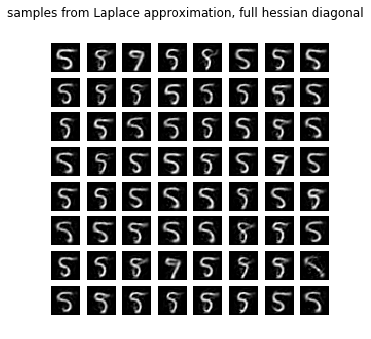

hessian successful 7


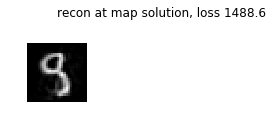

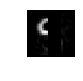

eigenvalues before and after inverse, approx hessian
[array([[9.9532610e-01, 9.9830204e-01, 9.9934679e-01, 9.9999911e-01,
        1.0000006e+00, 1.0004004e+00, 1.0008479e+00, 1.0023665e+00,
        1.0138566e+00, 2.7111644e+05]], dtype=float32), array([[3.68845266e-06, 9.97212200e-01, 9.98766501e-01, 9.99323681e-01,
        9.99753921e-01, 9.99999864e-01, 1.00000185e+00, 1.00025052e+00,
        1.00209442e+00, 1.00517907e+00]])]


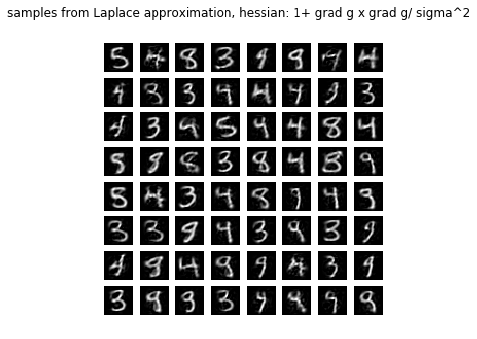

covariances
(1, 10, 10)


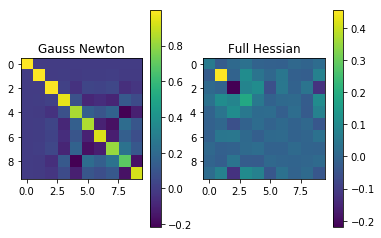

hessians
(1, 10, 10)


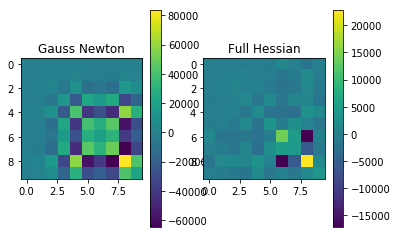

eigenvalues before and after inverse, full hessian
[array([[-2.6428301e+00,  1.8717953e+00,  4.7011766e+00,  1.7555874e+01,
         2.5988794e+01,  7.7629066e+01,  1.6552730e+02,  4.3537695e+03,
         9.3344180e+03,  3.9165691e+04]], dtype=float32), array([[-3.78350349e-01,  2.55325537e-05,  1.07130366e-04,
         2.29686044e-04,  6.04134529e-03,  1.28816955e-02,
         3.84785077e-02,  5.69612821e-02,  2.12725155e-01,
         5.34428488e-01]])]
1
full hessian fails


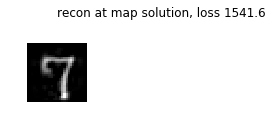

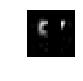

eigenvalues before and after inverse, approx hessian
[array([[9.9815595e-01, 9.9954629e-01, 9.9972928e-01, 9.9993855e-01,
        1.0000235e+00, 1.0000736e+00, 1.0000889e+00, 1.0001798e+00,
        1.0006067e+00, 4.1778297e+04]], dtype=float32), array([[2.39358704e-05, 9.99358729e-01, 9.99766947e-01, 9.99957320e-01,
        9.99993894e-01, 1.00000638e+00, 1.00003766e+00, 1.00015700e+00,
        1.00036954e+00, 1.00077379e+00]])]


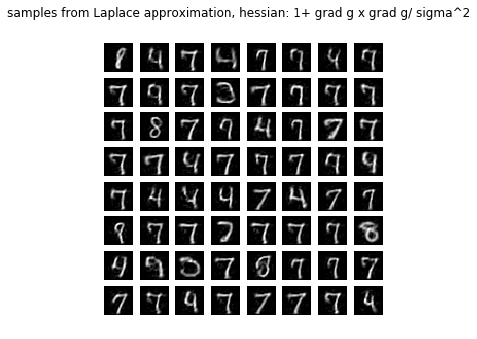

covariances
(1, 10, 10)


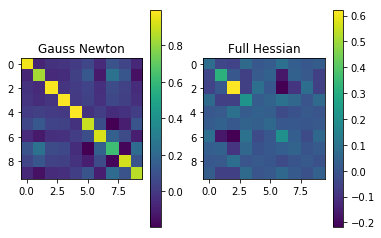

hessians
(1, 10, 10)


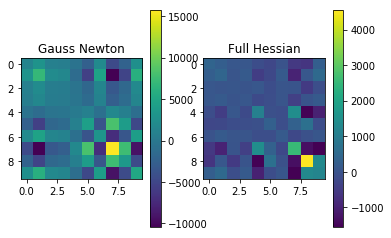

eigenvalues before and after inverse, full hessian
[array([[1.22623146e+00, 2.31345725e+00, 3.69113684e+00, 1.40716391e+01,
        2.07799129e+01, 1.12240486e+02, 1.84448364e+02, 2.92677765e+02,
        3.24542871e+03, 7.05801611e+03]], dtype=float32), array([[1.41682909e-04, 3.08125733e-04, 3.41672790e-03, 5.42158268e-03,
        8.90944760e-03, 4.81229195e-02, 7.10643675e-02, 2.70912588e-01,
        4.32272897e-01, 8.15495701e-01]])]
1


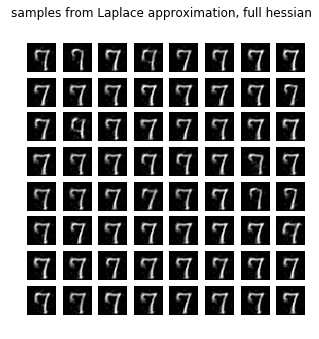

diagonal approx


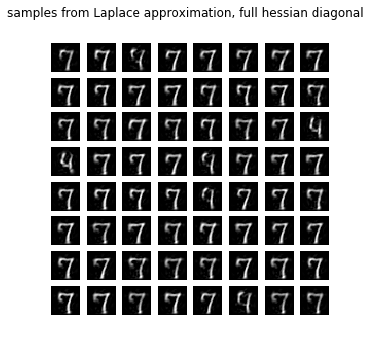

hessian successful 9


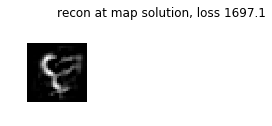

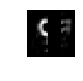

eigenvalues before and after inverse, approx hessian
[array([[9.9559331e-01, 9.9884772e-01, 9.9901122e-01, 9.9990743e-01,
        9.9999994e-01, 1.0000223e+00, 1.0003018e+00, 1.0024748e+00,
        1.0458896e+00, 3.9445344e+05]], dtype=float32), array([[2.53515369e-06, 9.91795086e-01, 9.98912819e-01, 9.99993264e-01,
        9.99999736e-01, 1.00002809e+00, 1.00011922e+00, 1.00049580e+00,
        1.00057634e+00, 1.00381618e+00]])]


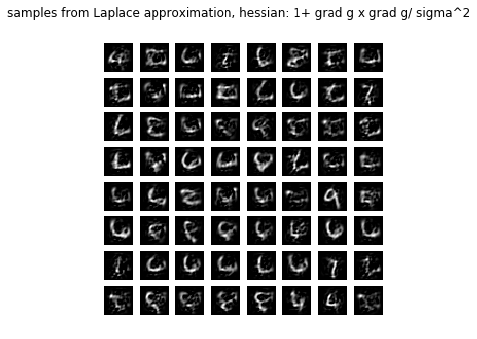

covariances
(1, 10, 10)


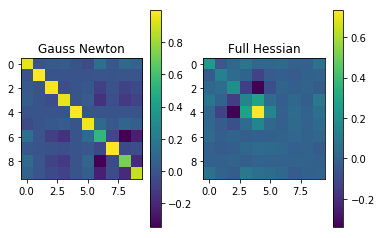

hessians
(1, 10, 10)


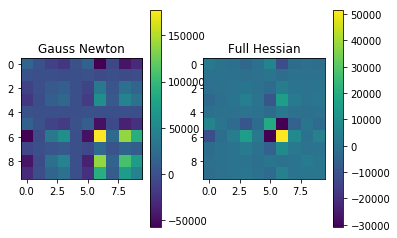

eigenvalues before and after inverse, full hessian
[array([[-1.0119912e+01,  9.3311870e-01,  3.4725330e+00,  6.2202044e+00,
         3.5699146e+01,  9.9398964e+01,  3.7231113e+02,  9.1243140e+02,
         5.0441494e+03,  7.9486109e+04]], dtype=float32), array([[-9.88354334e-02,  1.25808164e-05,  1.98249243e-04,
         1.09597265e-03,  2.68592087e-03,  1.00604906e-02,
         2.80120729e-02,  1.60775170e-01,  2.87994193e-01,
         1.07131293e+00]])]
1
full hessian fails


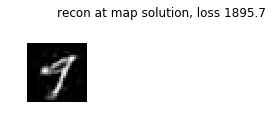

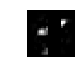

eigenvalues before and after inverse, approx hessian
[array([[9.9619961e-01, 9.9900854e-01, 9.9998605e-01, 9.9999762e-01,
        9.9999851e-01, 1.0000023e+00, 1.0000101e+00, 1.0006095e+00,
        1.0027888e+00, 7.0558094e+04]], dtype=float32), array([[1.41727164e-05, 9.99227092e-01, 9.99963629e-01, 9.99991838e-01,
        9.99998907e-01, 1.00000107e+00, 1.00000375e+00, 1.00000880e+00,
        1.00013252e+00, 1.00086678e+00]])]


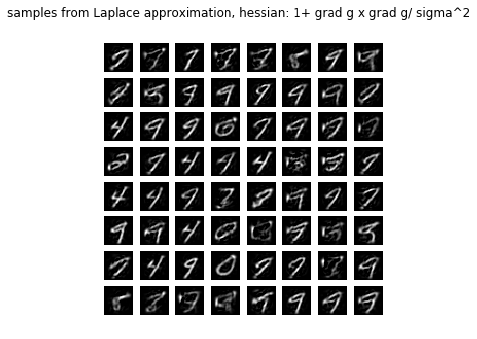

covariances
(1, 10, 10)


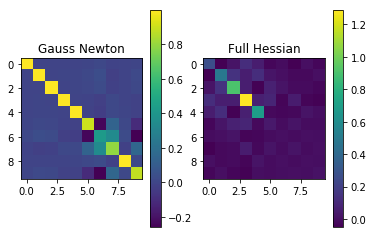

hessians
(1, 10, 10)


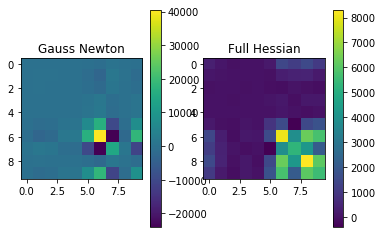

eigenvalues before and after inverse, full hessian
[array([[7.4420142e-01, 1.0586593e+00, 1.3509333e+00, 2.3704221e+00,
        4.2161160e+00, 3.6975395e+01, 7.9524544e+01, 1.8953179e+03,
        4.1372041e+03, 2.2350031e+04]], dtype=float32), array([[4.47426776e-05, 2.41709109e-04, 5.27616130e-04, 1.25747896e-02,
        2.70449386e-02, 2.37189328e-01, 4.21866783e-01, 7.40234204e-01,
        9.44586548e-01, 1.34371918e+00]])]
1


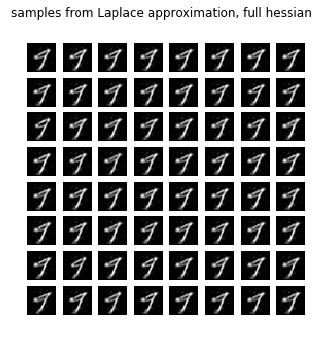

diagonal approx


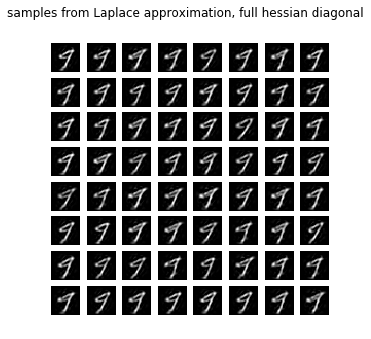

hessian successful 11


In [54]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis = [] 
# order minima by loss function value
l_minima   = np.asarray(l_minima)
map_minima = np.asarray(map_minima)
order      = np.argsort(l_minima)


# go through minima
for ii,ini_ in enumerate(map_minima[order]):
  
  
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:False})
  

  figure(figsize=(5,5))
  if ii==0:
    suptitle('recon at map solution, loss %.1f; start from truth'%l_minima[ii])
  else:
    suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()

  # get diagonal
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})]
  
  print('eigenvalues before and after inverse, approx hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False}))

  # get samples 
  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace approximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  
  
  ## plot sigma
  print('covariances')
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  print('hessians')
  sigma_m = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  sigma_m_t = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  print(sigma_m.shape)
  plt.figure()
  subplot(1,2,1)
  title('Gauss Newton')
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  title('Full Hessian')
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
  
  
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True}))
  try:
    for s in [1]:
      print(s)
   
      _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:s})
      figure(figsize=(5,5))
      suptitle('samples from Laplace approximation, full hessian')
      for i in range(sample_size_z):
          subplot(8,8,i+1)
          imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
          axis('off')
      plt.show()
      
    print('diagonal approx')
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, scale:1, diag_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, diag_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian diagonal')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
    print('hessian successful',ii)
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


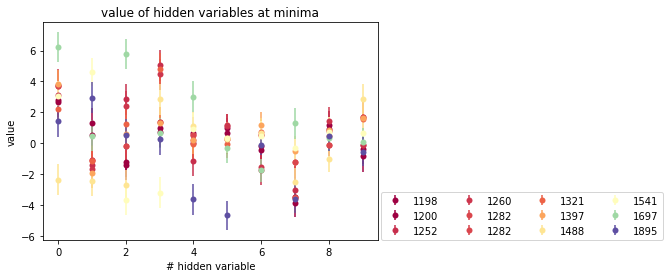

In [55]:
# check if minima are distinct
order = np.argsort(l_minima)
map_minima = np.asarray(map_minima[order])
l_minima   = np.asarray(l_minima[order])
varis      = np.asarray(varis)

colors = matplotlib.colors.Normalize(vmin=min(l_minima), vmax=max(l_minima))
cmap = matplotlib.cm.get_cmap('Spectral')

plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  yerr_= np.sqrt(varis[ii,0])

  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), marker='o',ls='', c=cmap(colors(l_minima[ii])), mew=0, yerr=yerr_, label ='%d'%l_minima[ii])
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.savefig(plot_path+'minima_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

**explore posterior around minima**

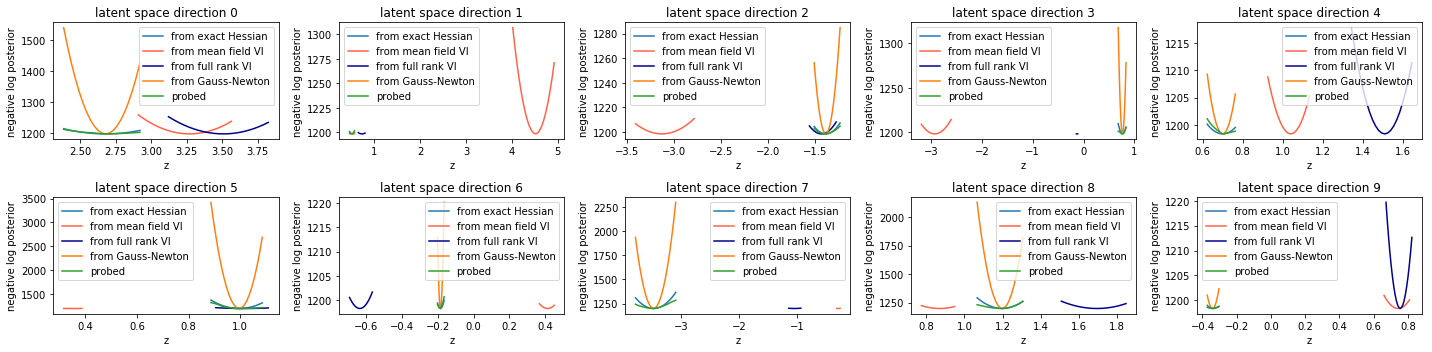

In [45]:
order     = np.argsort(l_minima)[0]

# testing Hessian
for ii,ini_ in enumerate([map_minima[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0]})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False})
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B    = measured_hessian[0,nn,nn]
    GN   = GN_hessian[0,nn,nn]
    VIm  = np.linalg.inv(VI_cov)[0,nn,nn]

    z_VI = (0.01*(np.arange(21)-11))*VI_mean[0,nn]
    
    VImf  = np.linalg.inv(VI_f_cov)[0,nn,nn]

    z_VIf = (0.01*(np.arange(21)-11))*VI_f_mean[0,nn]

    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(21):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-11))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new})
      losses.append(-ll)
    

    
    
    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+B*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from exact Hessian')
    plt.plot(z_VI+VI_mean[0,nn],-ll0+VIm*z_VI**2,label='from mean field VI', color='tomato')
    plt.plot(z_VIf+VI_f_mean[0,nn],-ll0+VImf*z_VIf**2,label='from full rank VI', color='darkblue')
    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+GN*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.plot(ini_[0][:,nn]+(0.01*(np.arange(21)-11))*ini_[0][:,nn],losses,label='probed')
    plt.legend()
    plt.xlabel('z')
    plt.ylabel('negative log posterior')
    plt.tight_layout()
    plt.savefig(plot_path+'probing_posterior_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')


**Build Gaussian Mixture Model**

In [68]:
mu_     =[]
sigma_  =[]
w_tilde =[]
#diag    =[]

order   = np.argsort(l_minima)
mus     = map_minima[[order[ii] for ii in [0,3,6,9]]]
# loop over components, start with lowest, go higher and higher
for ii in range(num_comp):
  
  # do Laplace approximation around this minimum
  print(sess.run(MAP_reset,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]}))
  mu_+=[sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:mus[ii][0]})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})]
  

  #diag+=[sess.run(lapl_variance_MAP,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  logdet_ = sess.run(log_det,feed_dict={x_corr: data, sigma_corr:sigma_new,true_hess:True})
  logprob = sess.run(posterior_MAP,feed_dict={x_corr: data, sigma_corr:sigma_new})
  print(logdet_,logprob,0.5*logdet_+logprob)
  w_tilde+=[np.exp(0.5*(logdet_+logprob))]

mu_    = np.reshape(np.asarray(mu_),[1,num_comp,hidden_size])
sigma_ = np.reshape(np.asarray(sigma_),[1,num_comp,hidden_size,hidden_size])

w_tilde= np.asarray(w_tilde)
print(w_tilde)

A = 1./np.sum(w_tilde)

w = w_tilde*A
w = np.squeeze(w)
print(w)


_=sess.run(update_a,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_b,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_c,feed_dict={x_corr: data, sigma_corr:sigma_new,mu_est: mu_, sigma_est: sigma_, w_est:w })



[[ 2.6803303   0.52356946 -1.3828627   0.76382756  0.7004655   0.9963898
  -0.18421985 -3.4723957   1.1985819  -0.34135965]]
[-44.36914811] [-1198.3513] [-1220.53589241]
[[ 3.7951667  -1.6510624   2.3925314   4.4520617   0.23327093  1.2078393
  -1.551943   -3.4825196   1.4199922  -0.1017135 ]]
[-48.0726248] [-1260.551] [-1284.58733779]
[[ 2.191185   -1.1606826   1.2627183   4.8200517  -0.02860851 -0.01195444
   0.7597676  -3.5183516   0.46312824  1.5675808 ]]
[-48.32293561] [-1321.3047] [-1345.46615531]
[[ 3.076045    4.615457   -3.649751   -3.1795743   0.954666    0.3555205
   0.46042356 -0.2979884   0.74972343  0.6651334 ]]
[-40.59078646] [-1541.5999] [-1561.89524675]
[[1.40177862e-270]
 [6.85464420e-285]
 [3.88275967e-298]
 [0.00000000e+000]]
[1.00000000e+00 4.88996200e-15 2.76988078e-28 0.00000000e+00]


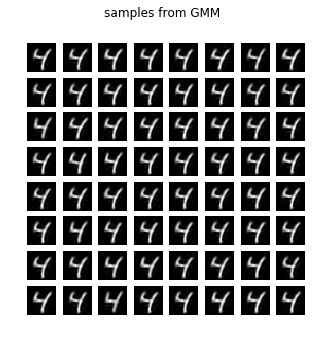

In [69]:
gmm_samples=sess.run(gmm_sample_x,feed_dict={x_corr: data, sigma_corr:sigma_new})

figure(figsize=(5,5))
suptitle('samples from GMM')
for i in range(sample_size_z):
    subplot(8,8,i+1)
    imshow(np.reshape(gmm_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.savefig(plot_path+'gmm_samples_xmin%d_xmax%d.png'%(minx,maxx),bbox_inches='tight')
plt.show()

**minima without nvp**

0
3890.3364
1959.1981
1959.5992
1959.0587
1958.3679
1958.3707
1958.4031
1958.424
1958.5094
1958.3202
1
2347.845
714.1892
715.21533
714.8303
713.9297
713.984
714.03064
713.88574
713.98016
713.7779
2
2684.6426
720.0725
720.7534
720.01984
719.5433
719.5436
719.5537
719.5471
719.5503
719.543
3
2544.466
715.8527
716.9342
714.77466
713.877
713.97455
713.9258
713.84827
713.9603
713.7777
4
2498.1372
1425.5186
1425.5586
1425.1626
1424.1106
1424.0955
1424.1638
1424.2406
1424.1365
1424.0698
5
1495.8269
721.3124
721.76624
721.59576
721.20325
721.2087
721.22675
721.1926
721.2185
721.17834
6
2995.2068
715.0438
714.2657
714.765
713.94763
713.83673
713.8225
714.0238
713.9539
713.7776
7
2245.8762
723.0961
722.8054
722.80585
722.4314
722.4642
722.47125
722.4327
722.4555
722.40546
8
2918.7454
1366.9164
1369.682
1365.2465
1364.7677
1364.7737
1364.6284
1364.7498
1364.9977
1364.4554
9
3899.258
720.5413
721.1754
720.9077
719.544
719.5429
719.5466
719.54803
719.55084
719.5427


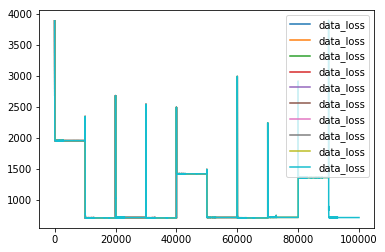

In [38]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(10):
  print(ii)
  ini = np.random.randn((batch_size2*hidden_size)).reshape((batch_size2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini, nvp_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op_MAP,loss_MAP],feed_dict={x_corr: data, nvp_prior: False, sigma_corr:sigma_new, lr:lrate})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False, lr:lrate})]
  plot(posterior_loss3,label='data_loss')
  legend()

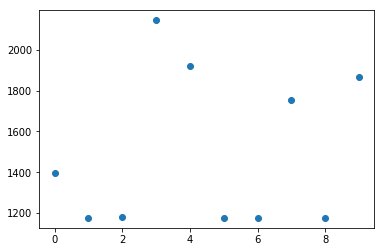

In [23]:
plt.figure()
plt.plot(np.arange(10),l_minima_old,ls='',marker='o')
plt.show()

In [125]:
import pickle
try:
  l_minima_old,map_minima_old = pickle.load(open(minima_path+'nvp_minima_nonnvp_xmin%d_xmax%d.pkl'%(minx,maxx),'rb'))
except:
  pickle.dump([l_minima_old,map_minima_old],open(minima_path+'nvp_minima_nonnvp_xmin%d_xmax%d.pkl'%(minx,maxx),'wb'))
  
map_minima_old = np.asarray(map_minima_old)
l_minima_old  = np.asarray(l_minima_old)

print(map_minima_old)

[[[[-0.7923539   1.5970947   1.5343508   0.04641243 -0.780231
    -0.6863949   1.1647897   0.31511375  1.1303812   0.3975146 ]]]


 [[[ 1.4395659  -0.05169467 -0.9570933  -0.22535267  1.7277365
    -0.51103675  0.05222924 -1.4663507   0.565135    1.2672961 ]]]


 [[[ 1.3863779  -0.46198204 -0.8511998  -0.25305322  1.686109
    -0.34971595  0.01644781 -1.5385765   0.6641998   0.95052224]]]


 [[[ 1.4395248  -0.0516899  -0.9570636  -0.22538324  1.7277769
    -0.5111041   0.05225403 -1.4663287   0.5651562   1.2672976 ]]]


 [[[ 0.43194094  0.22845057 -1.2477007  -0.35619962  1.5260986
    -0.22716324  1.4763312  -0.74448305  0.99762946 -0.26632553]]]


 [[[ 1.4682012  -0.23448974 -0.55505043 -0.24510293  1.6650419
    -0.37470245  0.17325807 -1.255145    0.59373885  1.3508488 ]]]


 [[[ 1.4396101  -0.05173619 -0.957069   -0.22538015  1.7276957
    -0.51101834  0.05218298 -1.4663926   0.56509984  1.267332  ]]]


 [[[ 1.4241133  -0.3957534  -0.57334936 -0.2593581   1.6363993
    -0.40029195

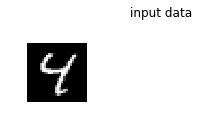

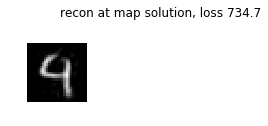

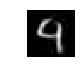

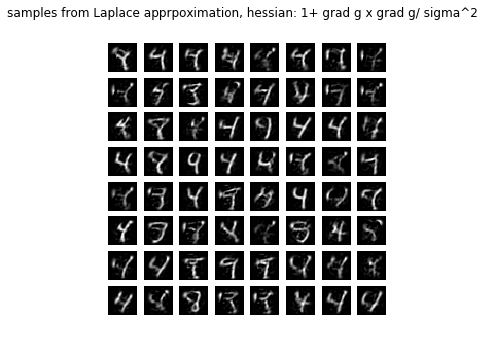

<Figure size 360x360 with 0 Axes>

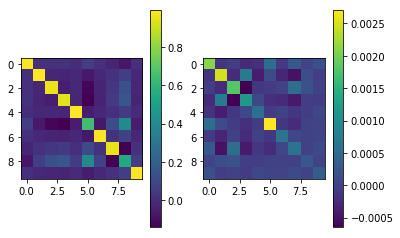

eigenvalues before and after inverse, full hessian
[array([[ 295.56754,  323.79993,  499.59866,  548.0393 , 1303.2059 ,
        1928.2512 , 2408.4624 , 2883.6624 , 4263.6104 , 6316.3467 ]],
      dtype=float32), array([[0.00015832, 0.00023454, 0.00034678, 0.0004152 , 0.0005186 ,
        0.00076734, 0.00182469, 0.00200161, 0.00308833, 0.00338332]])]


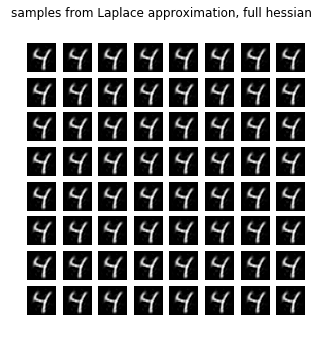

3668.8733
4529.705
3326.061
3351.1743
4875.9985
2776.5168
2532.6074
1941.6797
3053.084
3832.9746
2146.8596
3008.916
3297.4705
2859.096
3381.3179
3247.8804
2240.019
3554.5134
2462.25
3506.1858


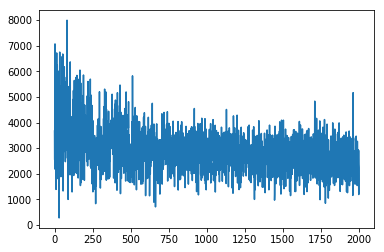

variance of VI [[-1.2170253   1.7620015   0.09897376 -1.8091397  -1.097841   -0.9518143
  -0.98718333 -0.13389398 -2.072787   -1.2791116 ]]


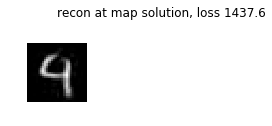

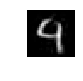

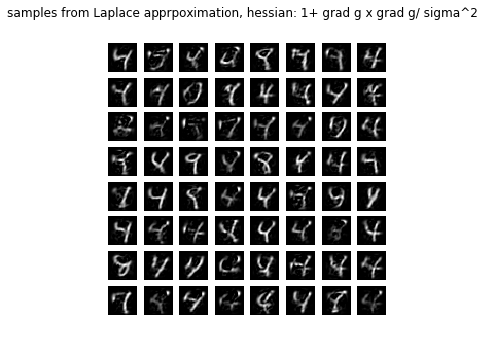

<Figure size 360x360 with 0 Axes>

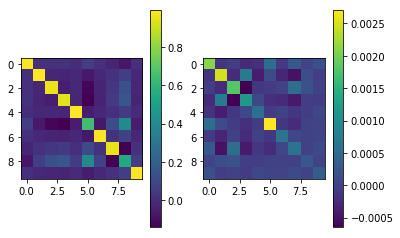

eigenvalues before and after inverse, full hessian
[array([[ 295.56754,  323.79993,  499.59866,  548.0393 , 1303.2059 ,
        1928.2512 , 2408.4624 , 2883.6624 , 4263.6104 , 6316.3467 ]],
      dtype=float32), array([[0.00015832, 0.00023454, 0.00034678, 0.0004152 , 0.0005186 ,
        0.00076734, 0.00182469, 0.00200161, 0.00308833, 0.00338332]])]


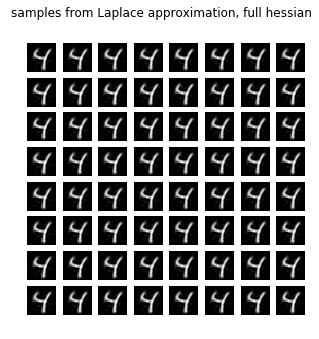

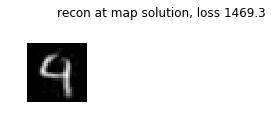

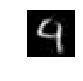

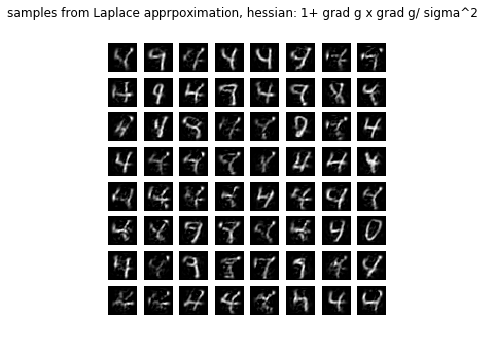

<Figure size 360x360 with 0 Axes>

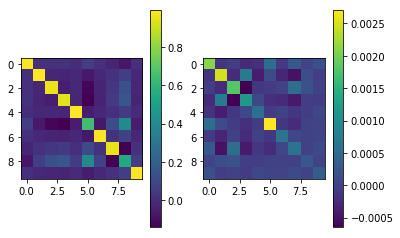

eigenvalues before and after inverse, full hessian
[array([[ 295.56754,  323.79993,  499.59866,  548.0393 , 1303.2059 ,
        1928.2512 , 2408.4624 , 2883.6624 , 4263.6104 , 6316.3467 ]],
      dtype=float32), array([[0.00015832, 0.00023454, 0.00034678, 0.0004152 , 0.0005186 ,
        0.00076734, 0.00182469, 0.00200161, 0.00308833, 0.00338332]])]


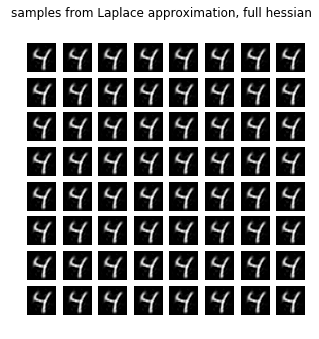

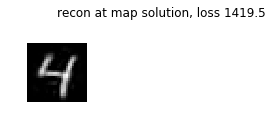

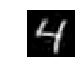

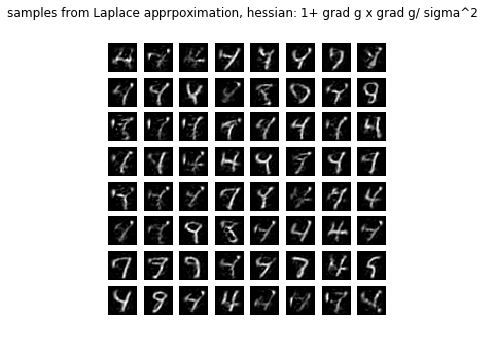

<Figure size 360x360 with 0 Axes>

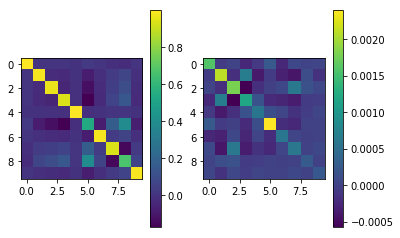

eigenvalues before and after inverse, full hessian
[array([[ 329.25522,  390.76392,  505.37305,  642.30615, 1251.9392 ,
        2089.7246 , 3148.4846 , 4194.1494 , 4512.867  , 5780.151  ]],
      dtype=float32), array([[0.00017301, 0.00022159, 0.00023843, 0.00031761, 0.00047853,
        0.00079876, 0.00155689, 0.00197874, 0.00255909, 0.00303716]])]


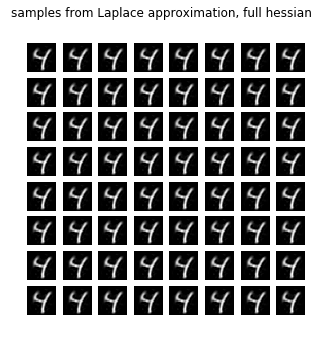

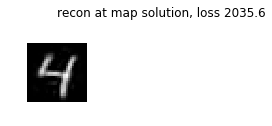

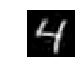

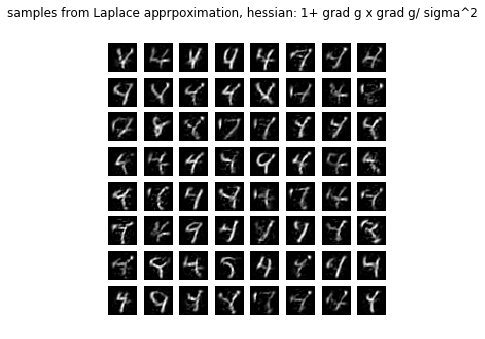

<Figure size 360x360 with 0 Axes>

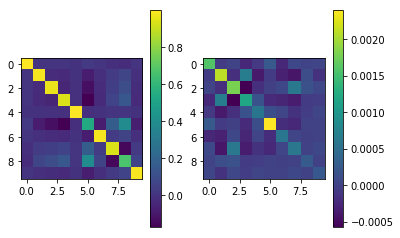

eigenvalues before and after inverse, full hessian
[array([[ 329.25522,  390.76392,  505.37305,  642.30615, 1251.9392 ,
        2089.7246 , 3148.4846 , 4194.1494 , 4512.867  , 5780.151  ]],
      dtype=float32), array([[0.00017301, 0.00022159, 0.00023843, 0.00031761, 0.00047853,
        0.00079876, 0.00155689, 0.00197874, 0.00255909, 0.00303716]])]


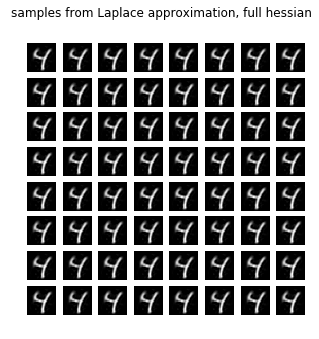

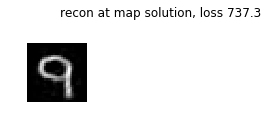

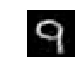

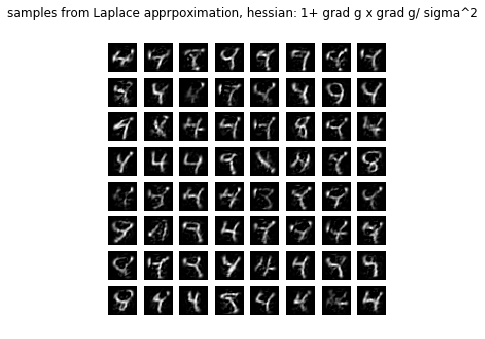

<Figure size 360x360 with 0 Axes>

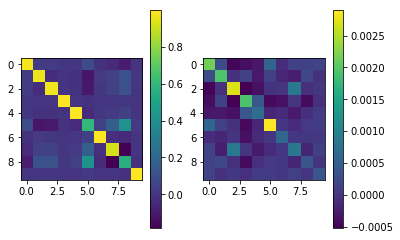

eigenvalues before and after inverse, full hessian
[array([[ 279.96597,  295.79144,  472.9282 ,  497.15036,  622.2537 ,
        1505.4579 , 1954.3016 , 2864.6968 , 4806.72   , 5976.8223 ]],
      dtype=float32), array([[0.00016731, 0.00020804, 0.00034908, 0.00051169, 0.00066425,
        0.00160706, 0.00201146, 0.00211449, 0.00338076, 0.00357186]])]


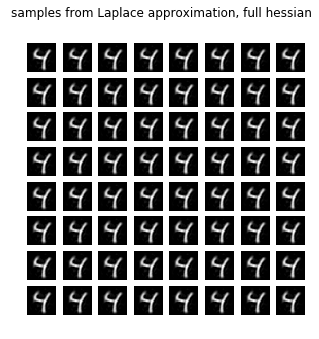

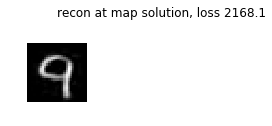

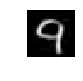

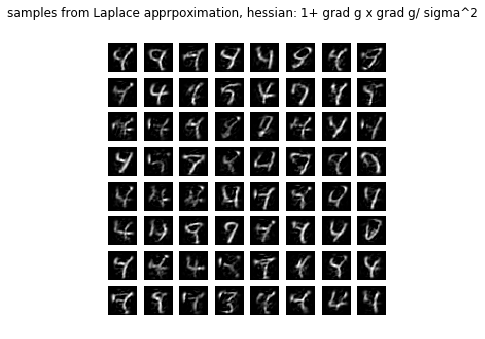

<Figure size 360x360 with 0 Axes>

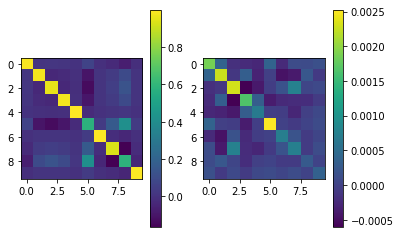

eigenvalues before and after inverse, full hessian
[array([[ 302.79645,  340.4805 ,  404.1211 ,  606.9125 ,  821.4269 ,
        1518.1434 , 1977.6283 , 2930.4229 , 5448.519  , 5482.971  ]],
      dtype=float32), array([[0.00018238, 0.00018354, 0.00034125, 0.00050566, 0.0006587 ,
        0.00121739, 0.00164768, 0.00247451, 0.00293702, 0.00330255]])]


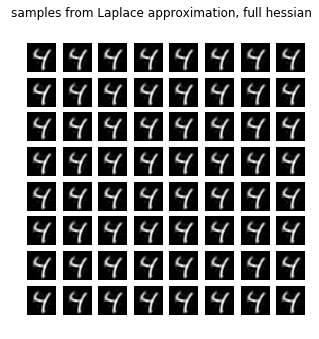

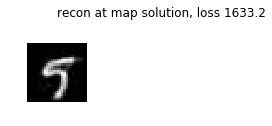

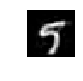

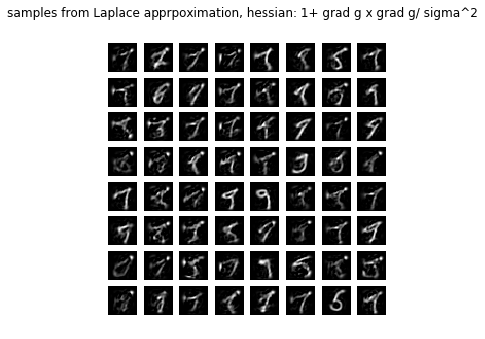

<Figure size 360x360 with 0 Axes>

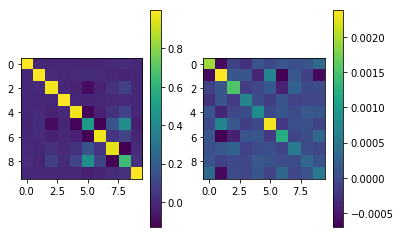

eigenvalues before and after inverse, full hessian
[array([[ 270.0749 ,  447.03912,  562.2821 ,  678.5729 , 1258.5518 ,
        1302.7478 , 1665.9392 , 2242.6946 , 3181.356  , 4399.3623 ]],
      dtype=float32), array([[0.00022731, 0.00031433, 0.00044589, 0.00060026, 0.00076761,
        0.00079456, 0.00147368, 0.00177847, 0.00223694, 0.00370268]])]


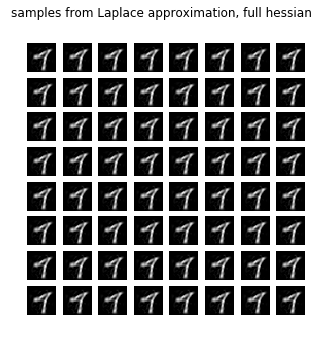

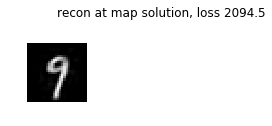

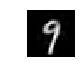

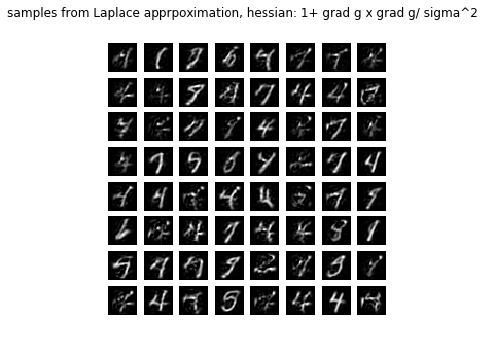

<Figure size 360x360 with 0 Axes>

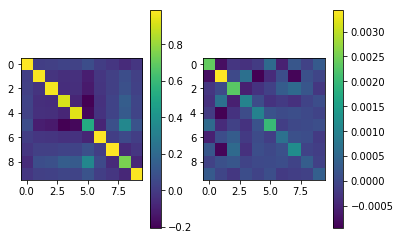

eigenvalues before and after inverse, full hessian
[array([[ 215.7159 ,  327.37067,  412.52216,  574.13824, 1279.0986 ,
        1365.5774 , 1837.0723 , 3068.643  , 3292.8608 , 4329.6123 ]],
      dtype=float32), array([[0.00023097, 0.00030369, 0.00032588, 0.00054434, 0.00073229,
        0.0007818 , 0.00174174, 0.00242411, 0.00305464, 0.00463573]])]


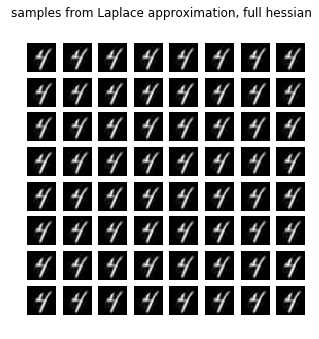

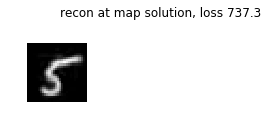

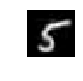

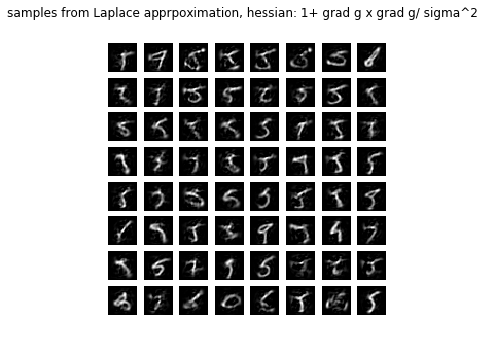

<Figure size 360x360 with 0 Axes>

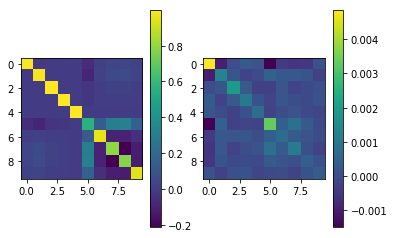

eigenvalues before and after inverse, full hessian
[array([[ 156.86053,  374.12003,  476.10394,  776.0871 ,  787.6871 ,
        1338.9464 , 1551.5988 , 2042.3889 , 3118.9053 , 5684.9727 ]],
      dtype=float32), array([[0.0001759 , 0.00032063, 0.00048962, 0.0006445 , 0.00074686,
        0.00126954, 0.00128851, 0.00210038, 0.00267294, 0.0063751 ]])]


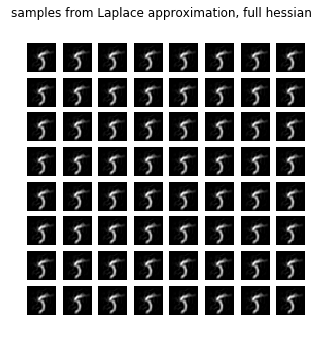

In [128]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

#order minimia
varis=[] 
l_minima_old=np.asarray(l_minima_old)
map_minima_old=np.asarray(map_minima_old)
order = np.argsort(l_minima_old)


for ii,ini_ in enumerate(map_minima_old[order]):
  
  # set MAP
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  mean_at_map = sess.run(likeli_MAP.mean(),feed_dict={x_corr: data, sigma_corr:sigma_new})
  
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask,(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
 
  # Laplace approximation
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})]

  l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  figure(figsize=(5,5))
  #mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))

  ## plot sigma
  
  sigma_m = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  sigma_m_t = sess.run(sigma_hess,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

  plt.figure()
  subplot(1,2,1)
  plt.imshow(sigma_m[0,:,:])
  plt.colorbar()
  subplot(1,2,2)
  plt.imshow(sigma_m_t[0,:,:])
  plt.colorbar()
  plt.show()
    
  #same for full hessian
  print('eigenvalues before and after inverse, full hessian')
  print(sess.run([eig1, eig2],feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False}))
  try:
    _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})

    l_samples = sess.run(lap_mean,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior: False})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  
  except:
    try:
      print('full hessian fails')
    except:
      print('eigen decomp fails')


#do vae on corrupted data with mean of posterior set to MAP values
  if ii ==0:
    _ = sess.run(update4,feed_dict={x_corr: data, sigma_corr:sigma_new, nvp_prior: False})   
    lrate=1e-2
    elbo_2_loss=[]
    for ii in range(2000):
      _, ll = sess.run([opt_op_elbo2, elbo],feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
      elbo_2_loss.append(ll)
      if ii%100==0:
        print(ll)
    plt.figure()
    plt.plot(elbo_2_loss)
    plt.show()
    
    elbo_var = sess.run(sigma_elbo,feed_dict={x_corr: data, lr:lrate, sigma_corr:sigma_new, nvp_prior: False})
    print('variance of VI', elbo_var)    


(1, 10, 10)


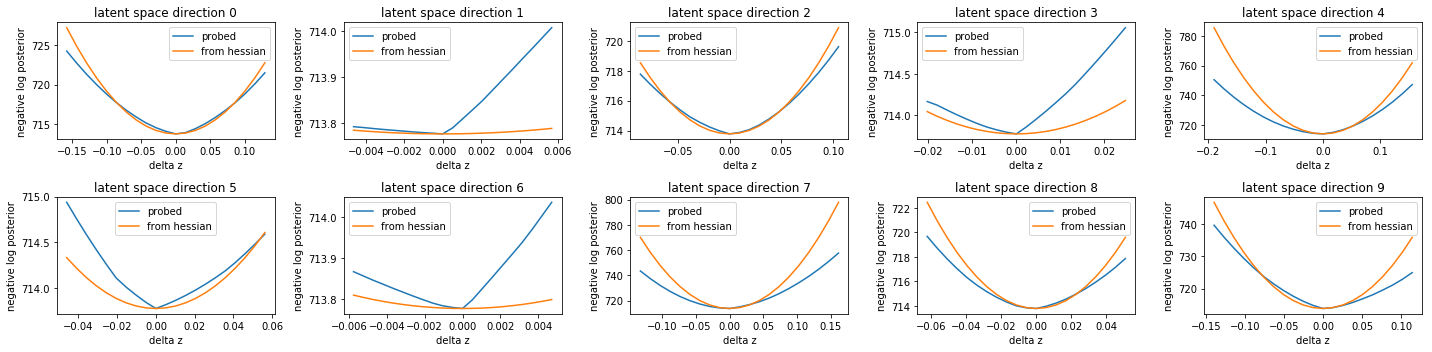

In [0]:
order     = np.argsort(l_minima_old)[0]
# testing Hessian
for ii,ini_ in enumerate([map_minima_old[order]]):
  
  # go through minima
  _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  # Laplace approximation with approximate Hessian
  _ = sess.run(update2,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], nvp_prior:False})
  _ = sess.run(update3,feed_dict={x_corr: data, sigma_corr:sigma_new, MAP_ini:ini_[0], true_hess:True, nvp_prior:False})
  measured_hessian = sess.run(hess2,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False})
  GN_hessian = sess.run(hess_approx,feed_dict={x_corr: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  print(GN_hessian.shape)
  ll0 = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  plt.figure(figsize=(20,5))
  
  for nn in np.arange(hidden_size):
    B = measured_hessian[0,nn,nn]
    GN = GN_hessian[0,nn,nn]
    elbo_v = 1./elbo_var[0,nn]**2
    losses=[]
    
    
    subplot(2,5,nn+1)
    #suptitle('negative log posterior')
    title('latent space direction %d'%nn)
    for jj in np.arange(21):
      delta_z = np.zeros_like(ini_[0])
      delta_z[:,nn] = (0.01*(jj-11))*ini_[0][:,nn]
      new_ini = ini_[0]+delta_z
      _ = sess.run(MAP_reset,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new, nvp_prior:False})
      ll = sess.run(posterior_MAP,feed_dict={x_corr: data, MAP_ini:new_ini, sigma_corr:sigma_new, nvp_prior:False})
      losses.append(-ll)
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],losses,label='probed')
    plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+B*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from hessian')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+elbo_v*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from VI', color='tomato')
    #plt.plot((0.01*(np.arange(21)-11))*ini_[0][:,nn],-ll0+GN*((0.01*(np.arange(21)-11))*ini_[0][:,nn])**2,label='from Gauss-Newton')
    plt.legend()
    plt.xlabel('delta z')
    plt.ylabel('negative log posterior')
    plt.tight_layout()


W0505 20:45:53.899823 140256009533312 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)


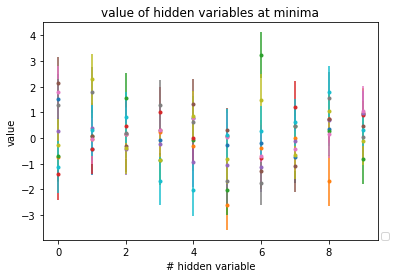

In [0]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

**do vae on corrupted data with mean of posterior set to MAP values**

---

